In [1]:
import pandas as pd
import numpy as np

from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

from src.datasets import daocensus_text
import src.utils.notebooks as nbutils

sns.set_theme()
plt.rcParams['figure.dpi'] = 600

In [2]:
# 'ORG_NAME', 'ORG_PLATFORM', 'SPLITS_FREQ', 'SPLITS_NORMALIZE', 'LAST_SPLITS', 'USE_ORG_NAMES'

ORG_NAME = 'Aave - Aavegotchi'
ORG_PLATFORM = 'snapshot'
USE_ORG_NAMES = True

# Not used
SPLITS_FREQ = ...
SPLITS_NORMALIZE = ...
LAST_SPLITS = ...

In [3]:
# Parameters
ORG_NAME = "Index Coop"
ORG_PLATFORM = "snapshot"
SPLITS_FREQ = "W-THU"
SPLITS_NORMALIZE = True
LAST_SPLITS = 10
USE_ORG_NAMES = True
EXECUTION_ID = "2024-03-01 12s:00"


In [4]:
dfv, dfp = daocensus_text.get('./data/daos-census-text', ORG_NAME, ORG_PLATFORM, use_org_names=USE_ORG_NAMES)
dfp = dfp.set_index('id')
print(dfv.info())
print(dfp.info())

Warning, removing 24031 votes without proposal
<class 'pandas.core.frame.DataFrame'>
Int64Index: 24031 entries, 0 to 24030
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   platform       24031 non-null  object        
 1   name           24031 non-null  object        
 2   id             24031 non-null  object        
 3   proposal       24031 non-null  category      
 4   deployment     24031 non-null  object        
 5   platform_vote  24031 non-null  object        
 6   voter          24031 non-null  category      
 7   date           24031 non-null  datetime64[ns]
 8   choice         24031 non-null  object        
 9   weight         24031 non-null  float64       
dtypes: category(2), datetime64[ns](1), float64(1), object(6)
memory usage: 1.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
CategoricalIndex: 874 entries, e2b5bee1-71b4-50f9-ad3e-7f3658ab7bfb to ebe47c59-d740-5459-b69f-e076f43209

# Exploración de datos de Decentraland

In [5]:
print(f"{ORG_NAME} tiene {len(dfv)} votos de {dfv['voter'].nunique()} voters en {dfv['proposal'].nunique()} propuestas")

Index Coop tiene 24031 votos de 2871 voters en 874 propuestas


In [6]:
dfd = dfp[['platform', 'name', 'platform_deployment']].drop_duplicates()
dfd

platform        name platform_deployment
id                                                                            
e2b5bee1-71b4-50f9-ad3e-7f3658ab7bfb  snapshot  Index Coop      index-coop.eth

## Histograma de votos por usuario

2871
47
count    2871.000000
mean        8.370254
std        28.464327
min         1.000000
50%         1.000000
90%        16.000000
95%        37.000000
99%       127.300000
max       535.000000
dtype: float64


Cannot show ipywidgets in text

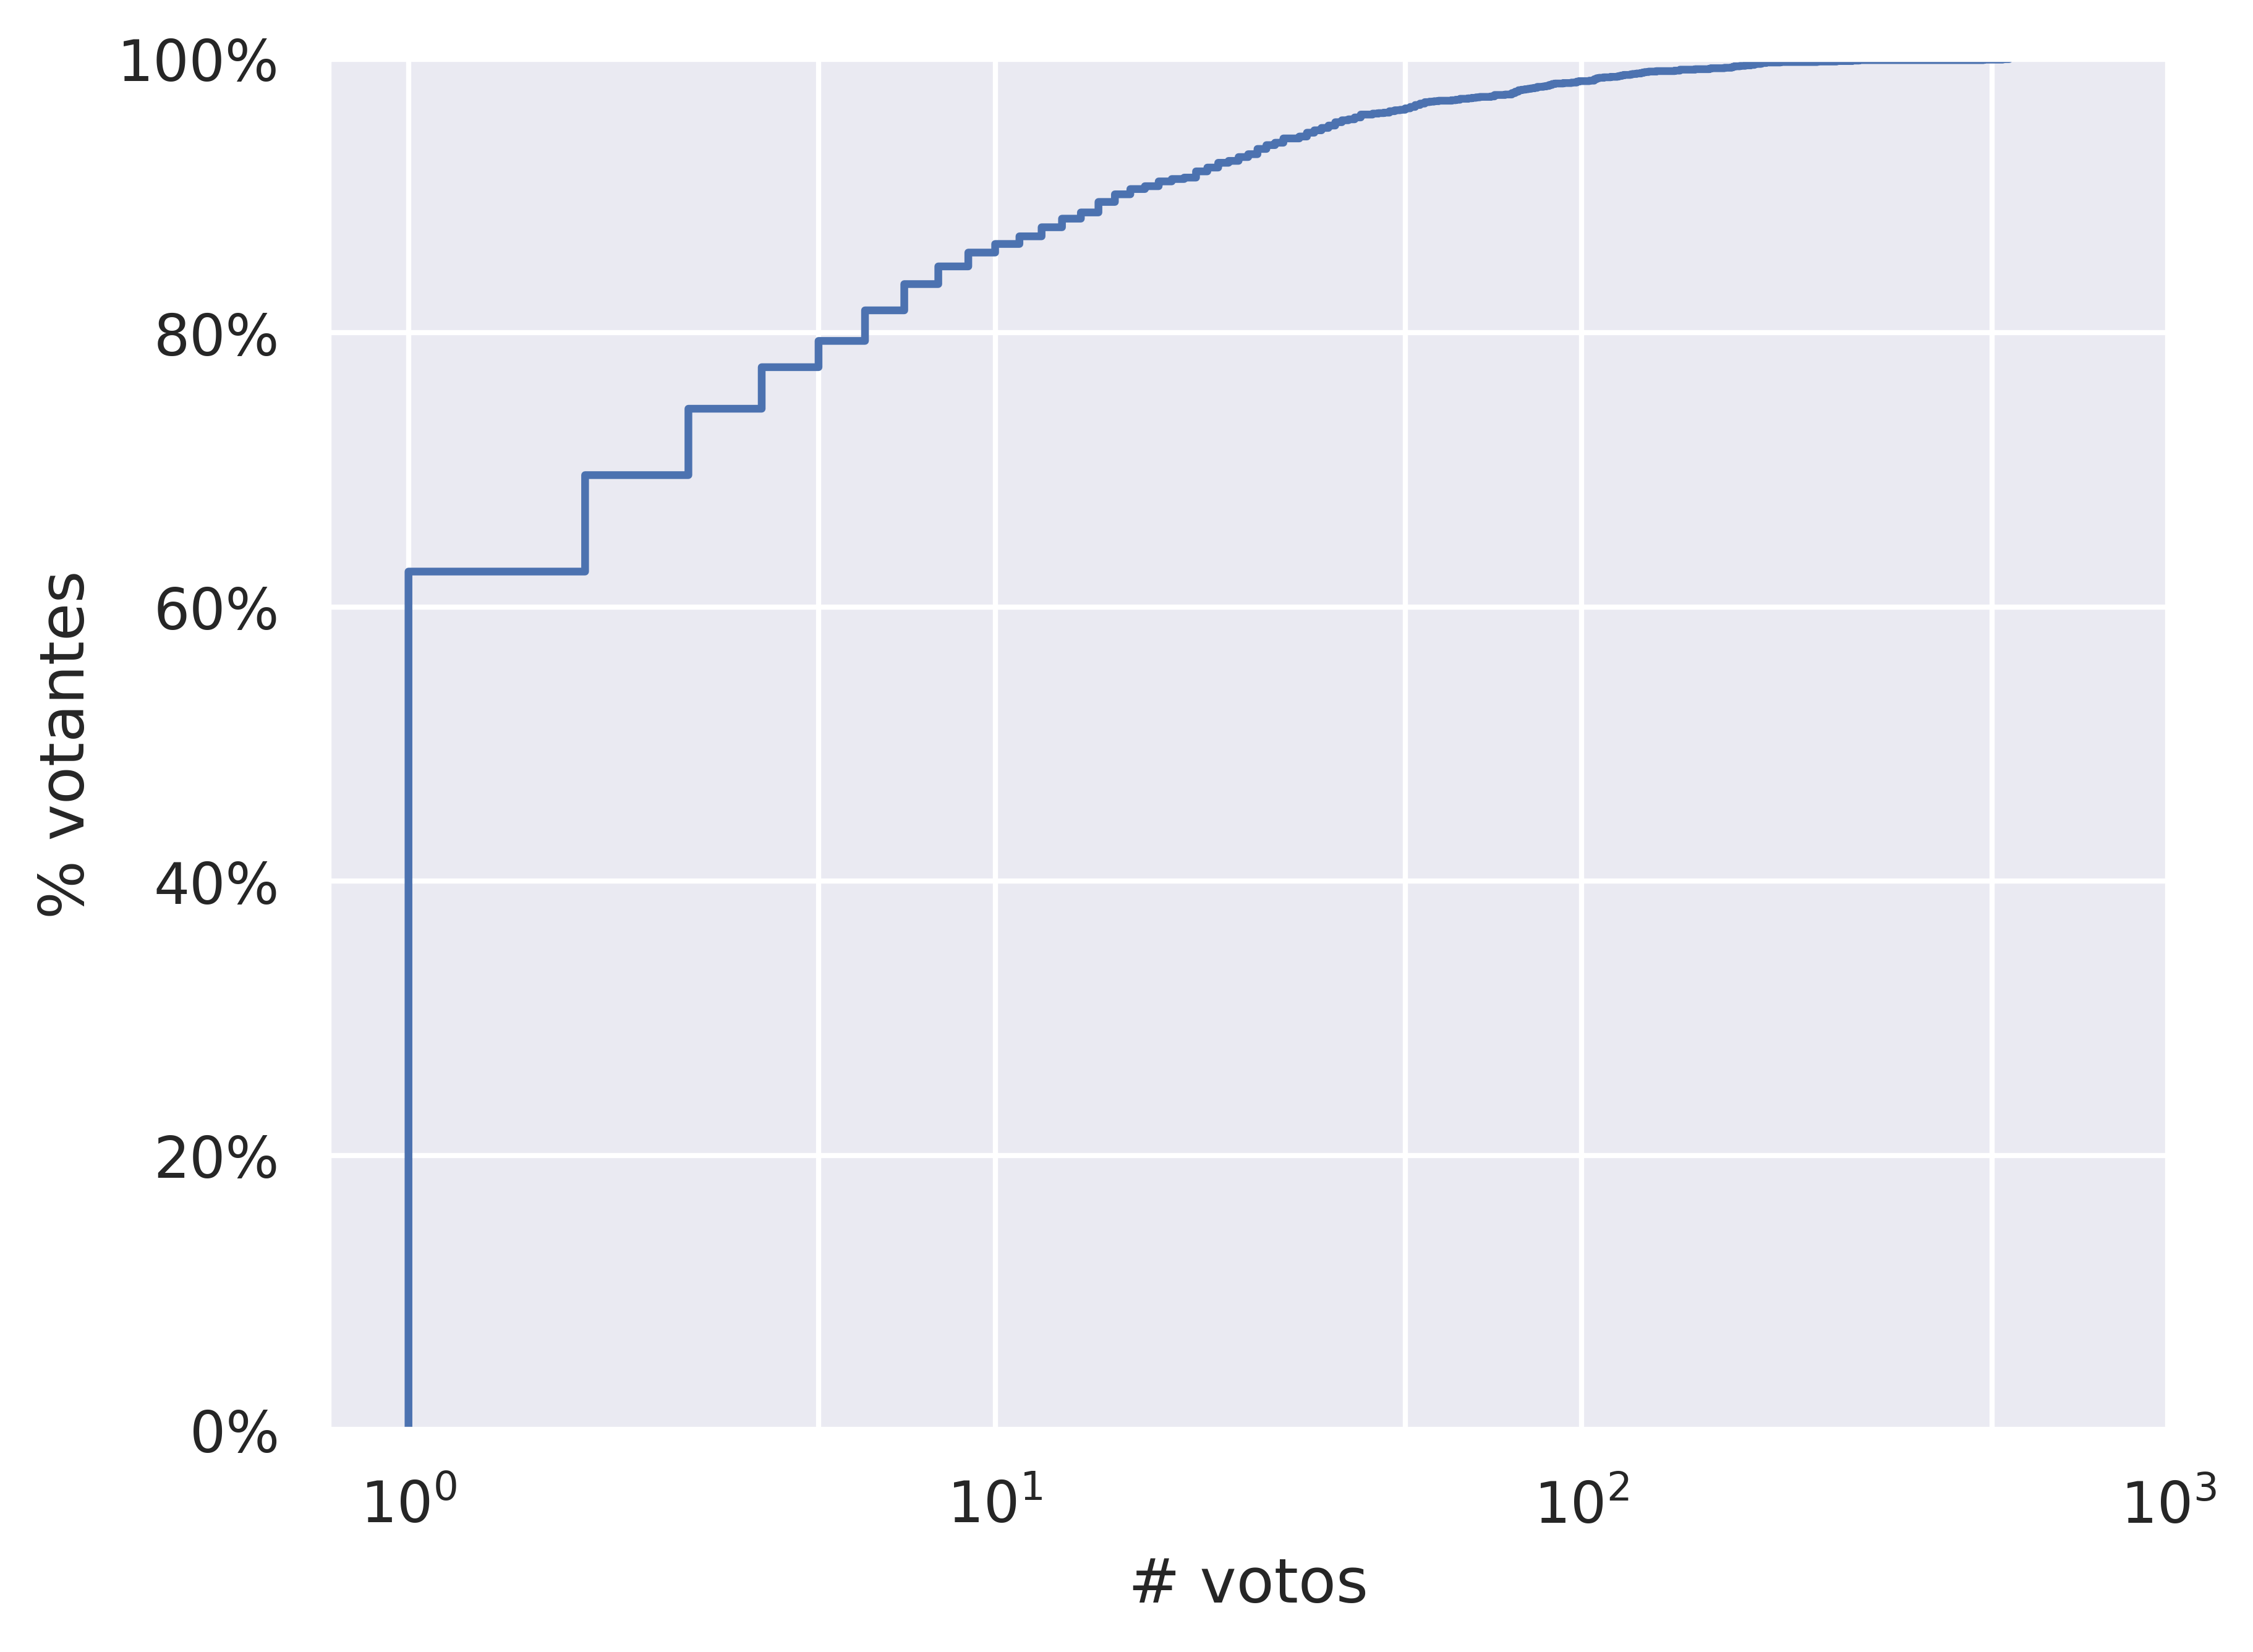

In [7]:
_toplot = dfv.groupby('voter').size()
# _toplot = _toplot[_toplot < 40]
print( len(_toplot) )
print( (_toplot > 100).sum() )
print(_toplot.describe(percentiles=[.5, .9, .95, .99]))
# _toplot.plot.hist(log=True)
ax = sns.ecdfplot(_toplot, log_scale=True)
plt.xlabel('# votos')
plt.ylabel('% votantes')

ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
# ax.xaxis.set_major_locator(mtick.MultipleLocator(10))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
nbutils.download_matplotlib(ax.figure, f'04_hybrid_ecdf_voters_{ORG_NAME}.pdf')

## Histograma de votos por propuesta

count     874.000000
mean       27.495423
std        51.934871
min         1.000000
50%        16.500000
75%        34.000000
90%        60.700000
95%        78.000000
99%       124.080000
max      1367.000000
Name: votes_count, dtype: float64
1


Cannot show ipywidgets in text

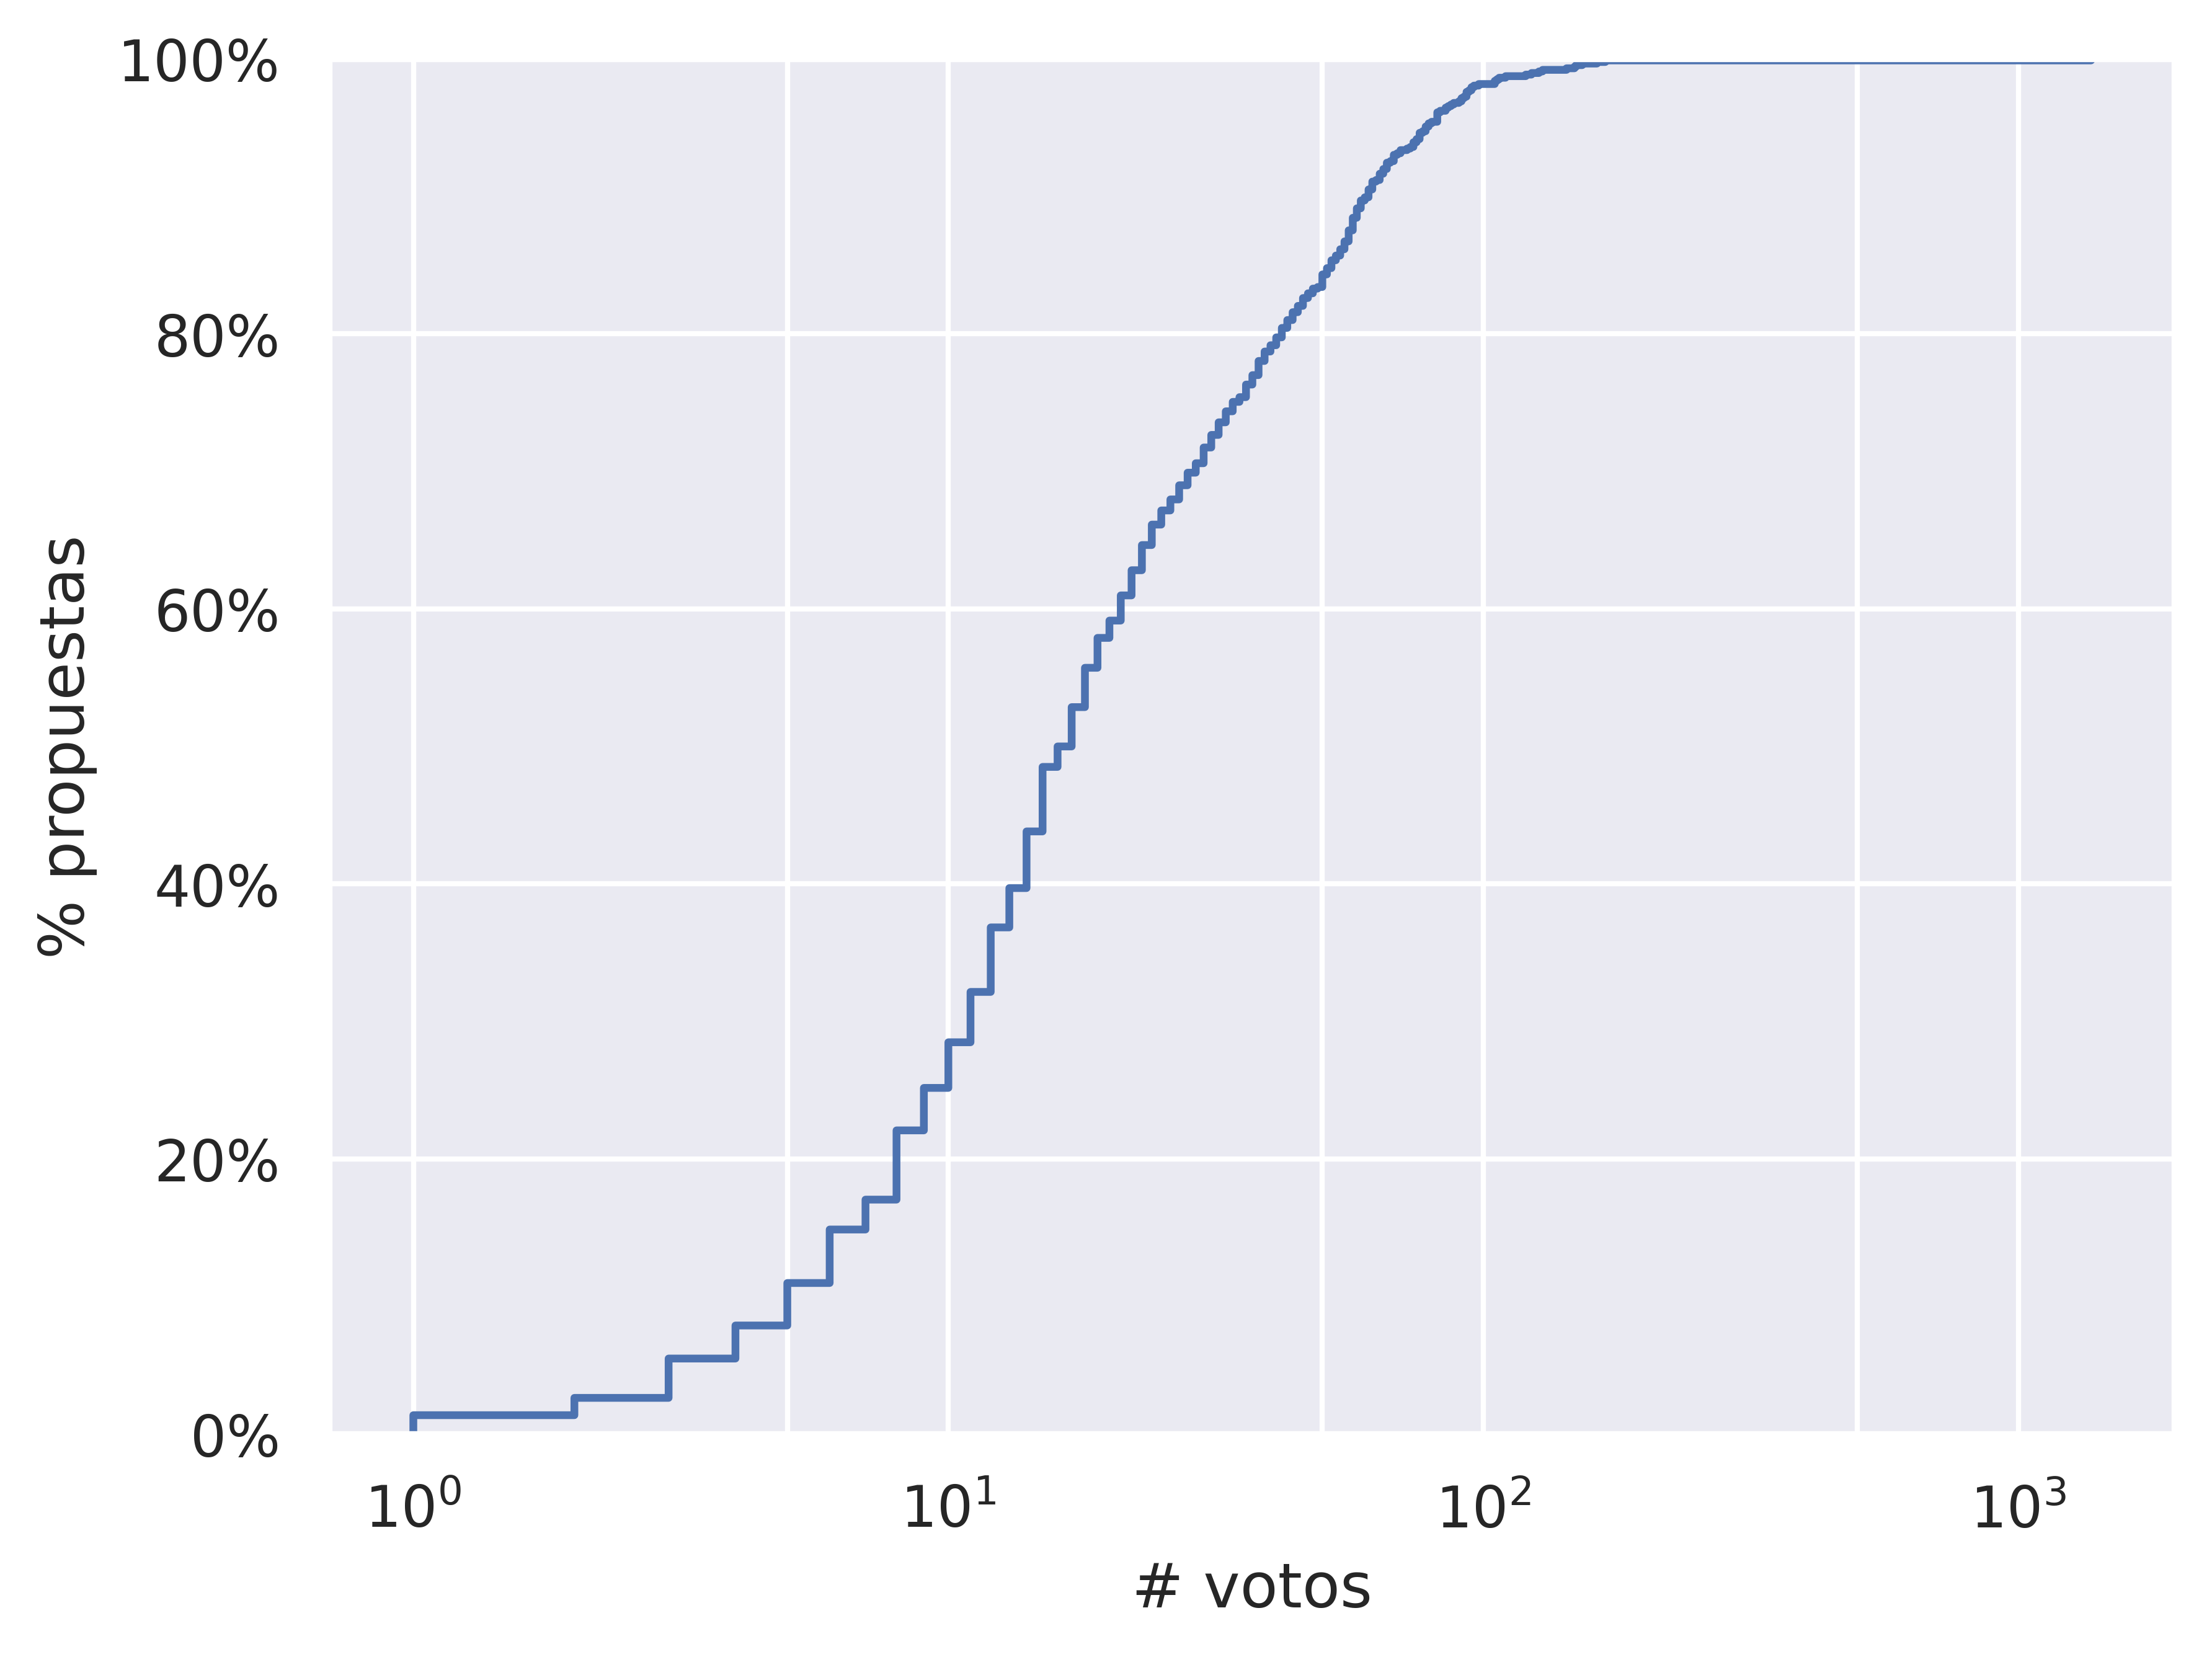

In [8]:
_toplot = dfp['votes_count']
print(_toplot.describe(percentiles=[.5,.75,.9, .95, .99]))
print( (_toplot > 300).sum() )

ax = sns.ecdfplot(_toplot, log_scale=True)
ax.set_xticks([1, 5, 10, 50, 100, 500, 1000])
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.xlabel('# votos')
plt.ylabel('% propuestas')

nbutils.download_matplotlib(ax.figure, f'04_hybrid_ecdf_proposals_{ORG_NAME}.pdf')

count     874.000000
mean       27.495423
std        51.934871
min         1.000000
50%        16.500000
75%        34.000000
90%        60.700000
95%        78.000000
99%       124.080000
max      1367.000000
dtype: float64
1


<Axes: ylabel='Proportion'>

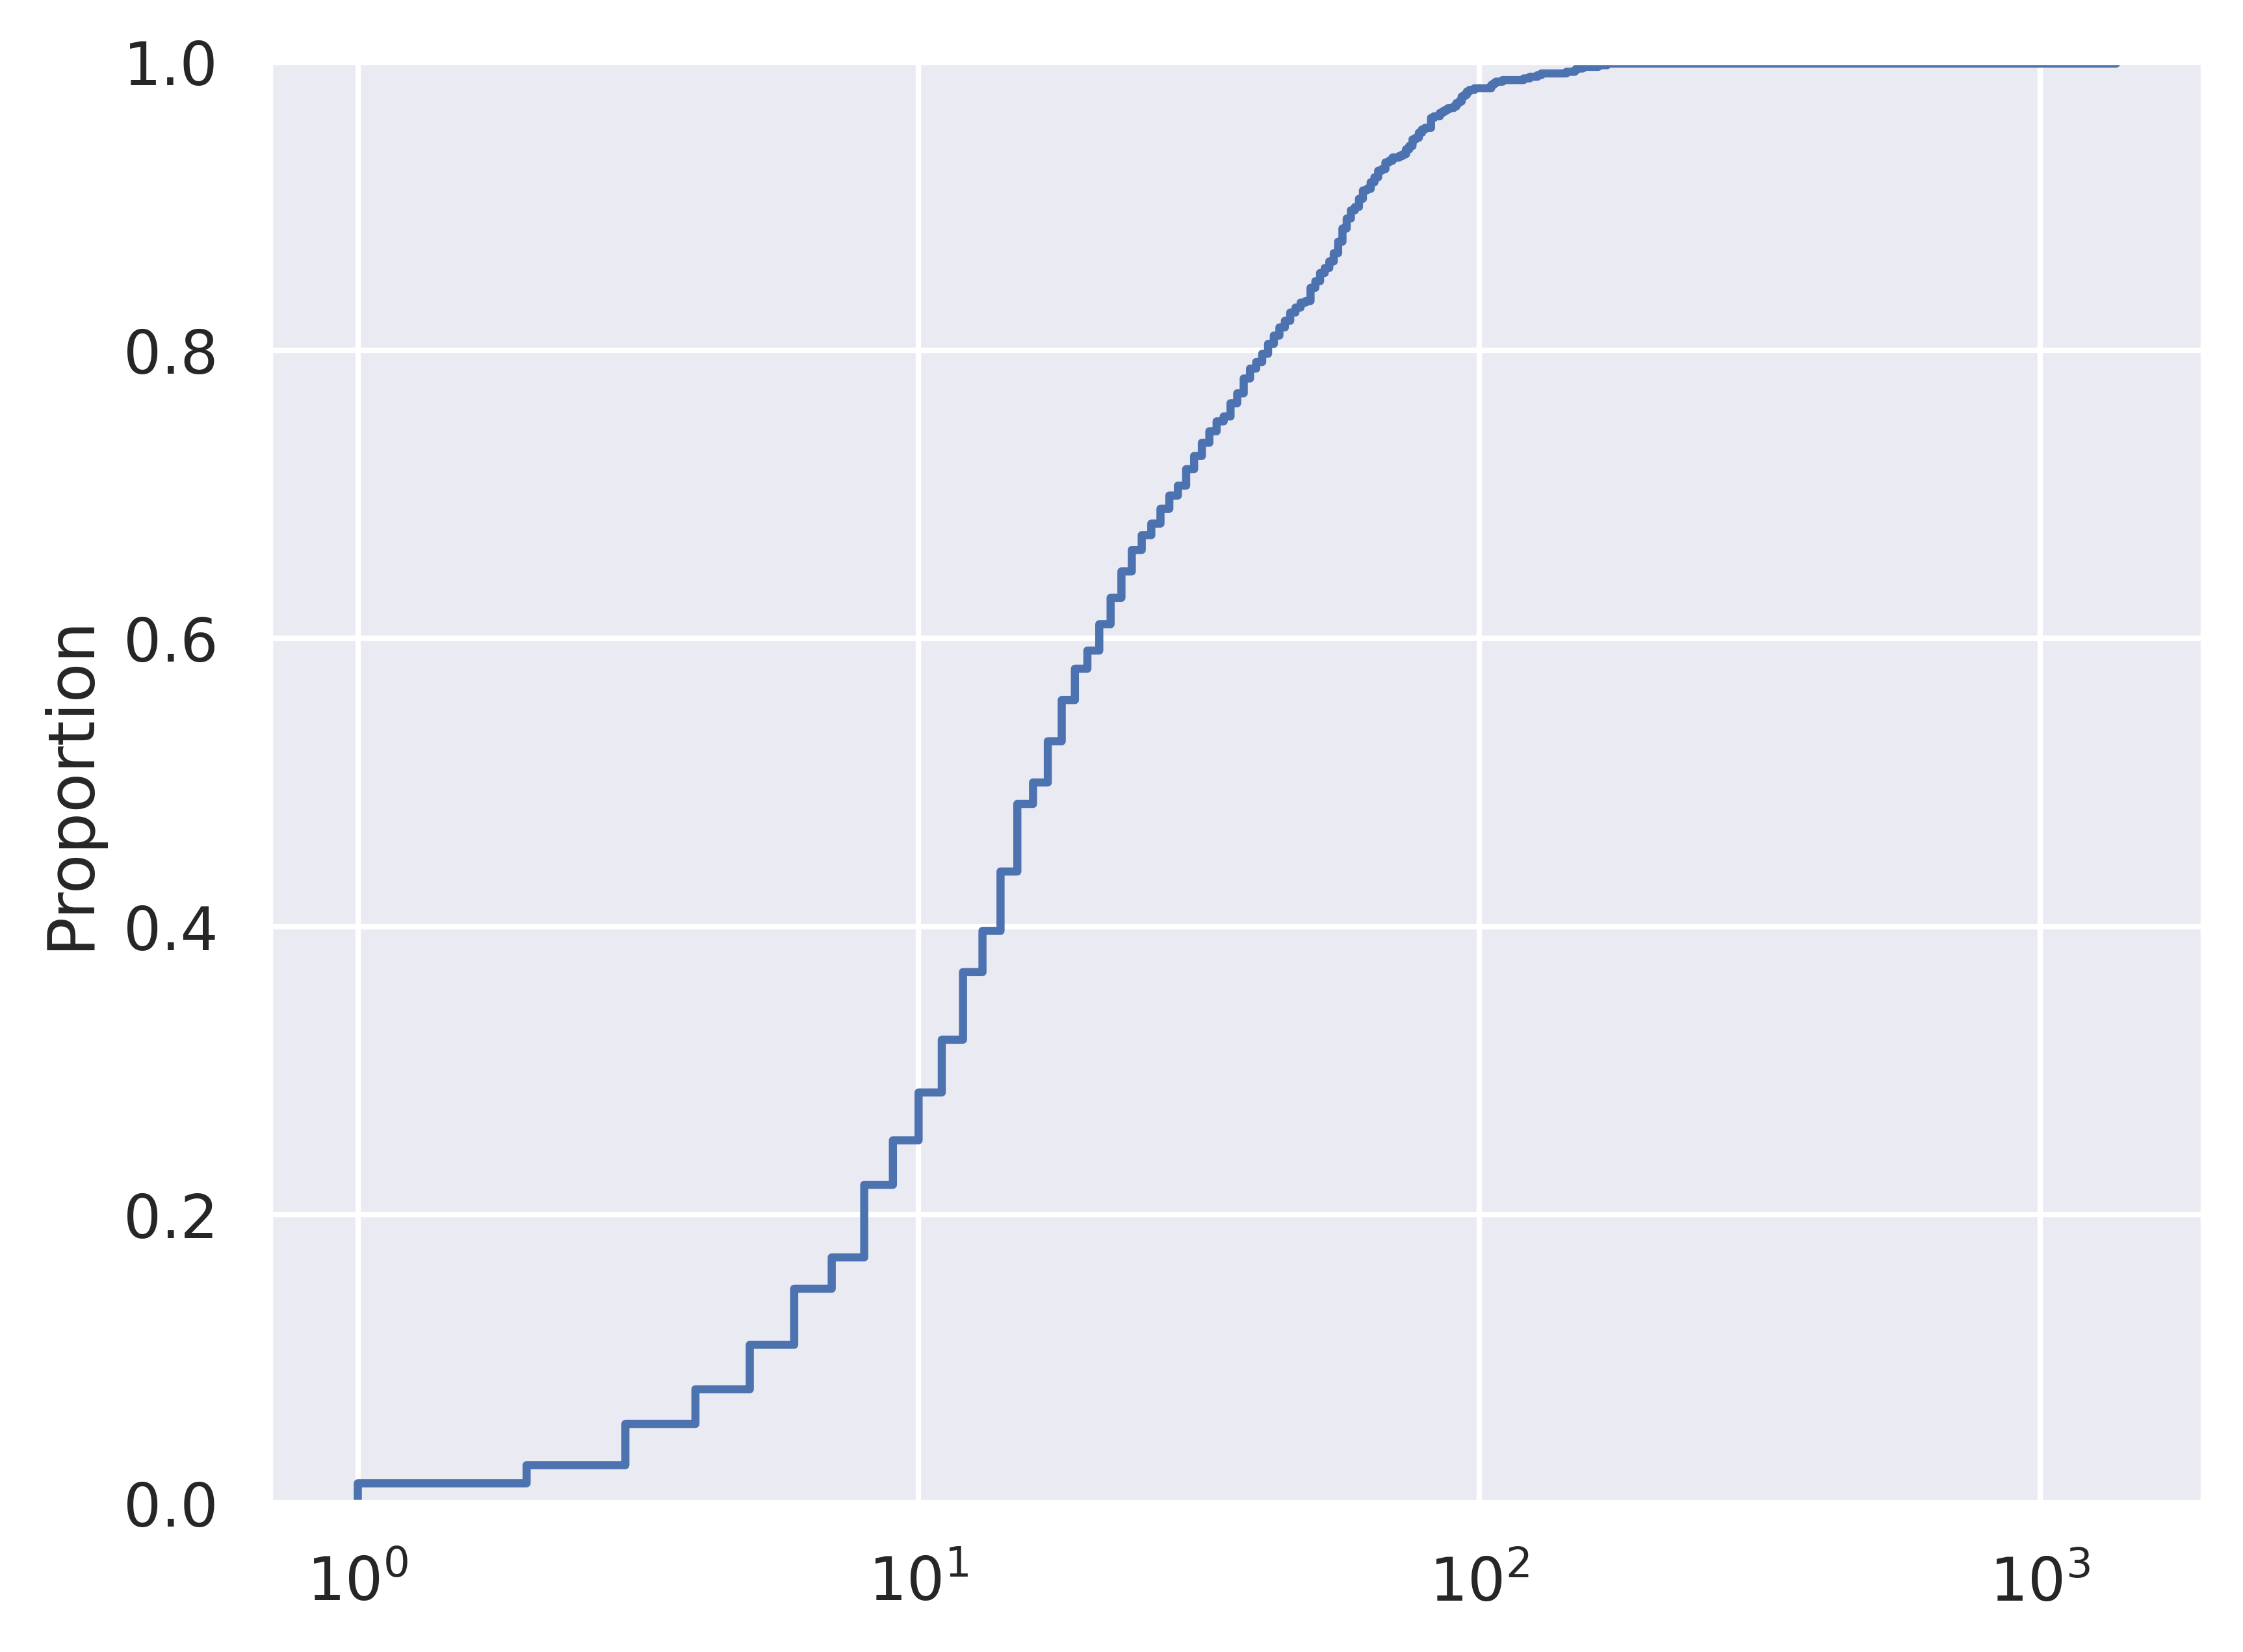

In [9]:
_toplot = dfv.groupby('proposal').size()
print(_toplot.describe(percentiles=[.5,.75,.9, .95, .99]))
print( (_toplot > 300).sum() )
sns.ecdfplot(_toplot, log_scale=True)

### Usuarios activos

In [10]:
# dfv.set_index('date').sort_index()['voter'].tolist()
# for x in dfv.set_index('date').sort_index()['voter'].items():
#     print(x)

/tmp/ipykernel_183180/3928196604.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


  0%|          | 0/24031 [00:00<?, ?it/s]

2020-11-18 20:56:32 2023-07-19 14:30:54


Cannot show ipywidgets in text

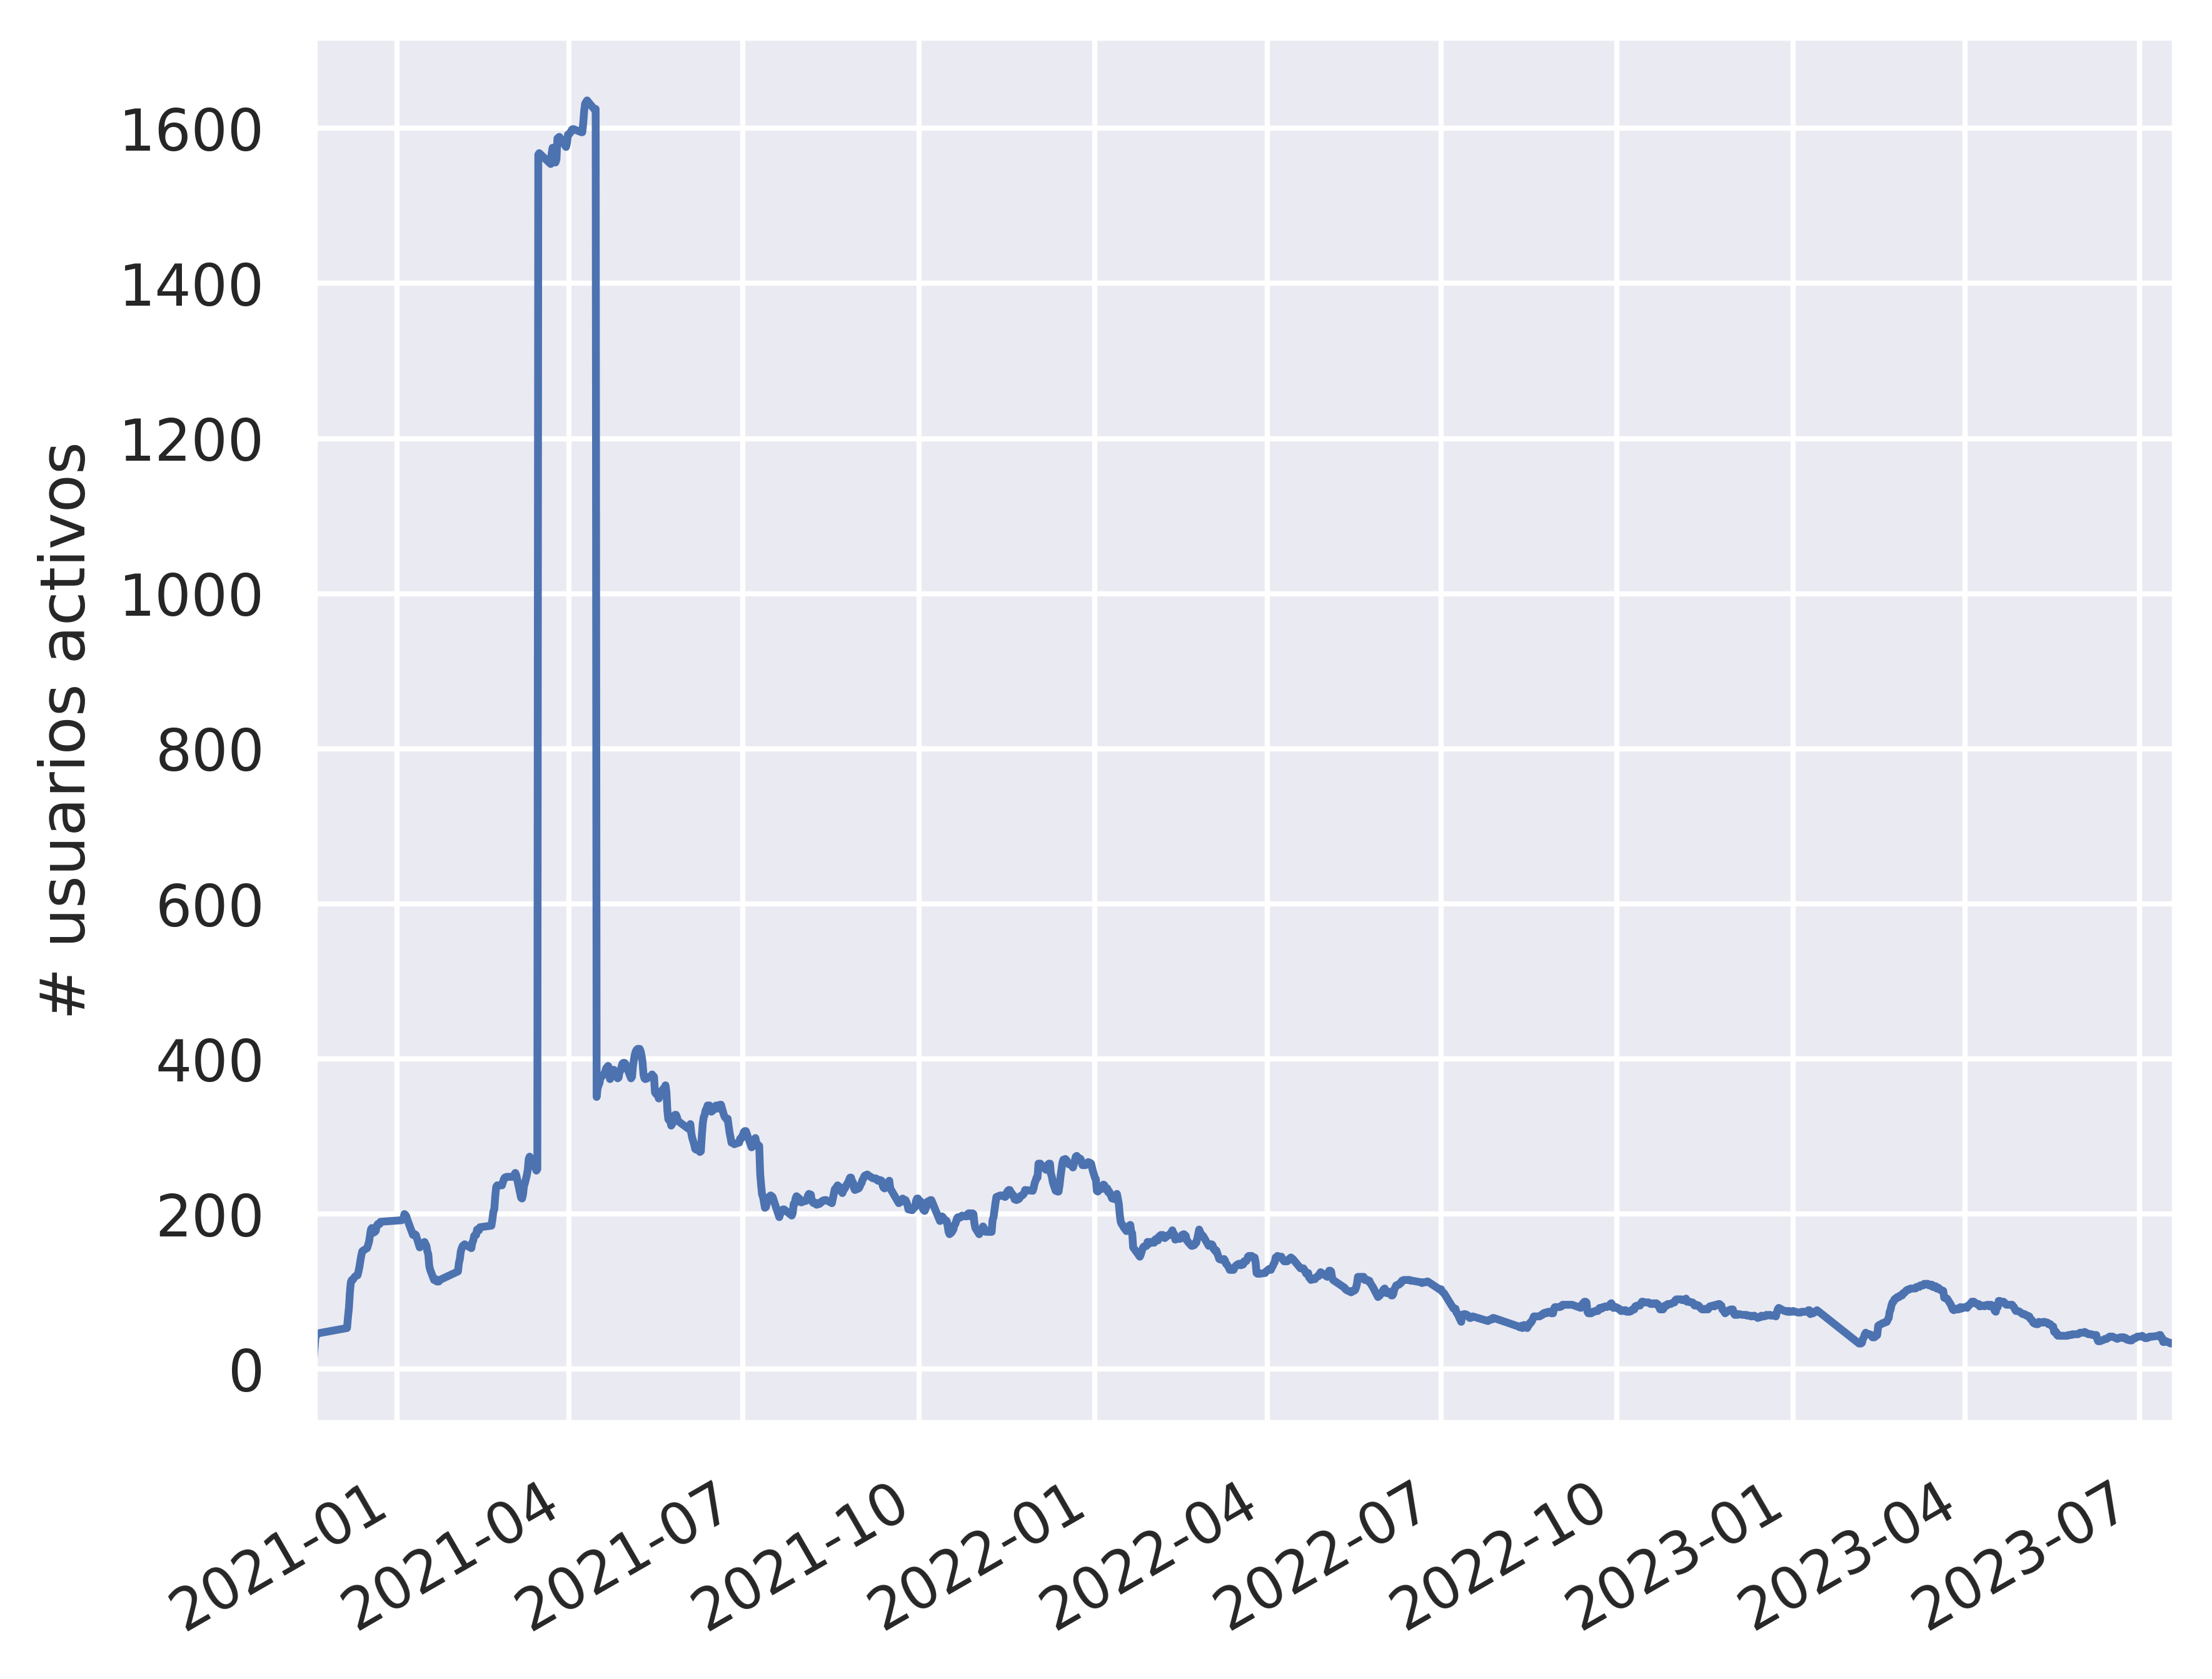

In [11]:
# import numba
from tqdm.autonotebook import tqdm
import rolling
import datetime as dt

tqdm.pandas(total=len(dfv))

# WINDOW_SIZE = '30D'
WINDOW_SIZE = dt.timedelta(days=30)

RESAMPLE_FREQ = '12h'

# @numba.jit(nopython=True)
# def nunique(arr):
#     return len(set(arr))

# Rolling no acepta tipos no númericos en la agregación, por lo que es necesario convertir la categoría a entero
# Por ejemplo, usando el código que le asigna Pandas
# dfv['ucode'] = dfv['voter'].cat.codes
#_cnt = dfv.set_index('date').sort_index().rolling(WINDOW_SIZE)['ucode'].progress_apply(nunique, raw=True).rename('cnt')

# Al final resulta que lo mejor era ir a por la solución O(1)
_voters = dfv.set_index('date').sort_index()['voter'] # .cat.codes
r = tqdm(
    rolling.arithmetic.Nunique(_voters.items(), WINDOW_SIZE, window_type='indexed'),
    total=len(dfv),
)
_cnt = pd.Series(r, index=_voters.index)
# Need to resample or there would be too many points
_cnt = _cnt.resample(RESAMPLE_FREQ).max()

print(dfv['date'].min(), dfv['date'].max())
ax = sns.lineplot(_cnt)
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# usuarios activos')
plt.xlim(dfv['date'].min(), dfv['date'].max())
nbutils.download_matplotlib(ax.figure, f'04c_rolling_voters_{WINDOW_SIZE}_{ORG_NAME}.png')

## Cuando se unen los usuarios

Es decir, cuando votan por primera vez

Cannot show ipywidgets in text

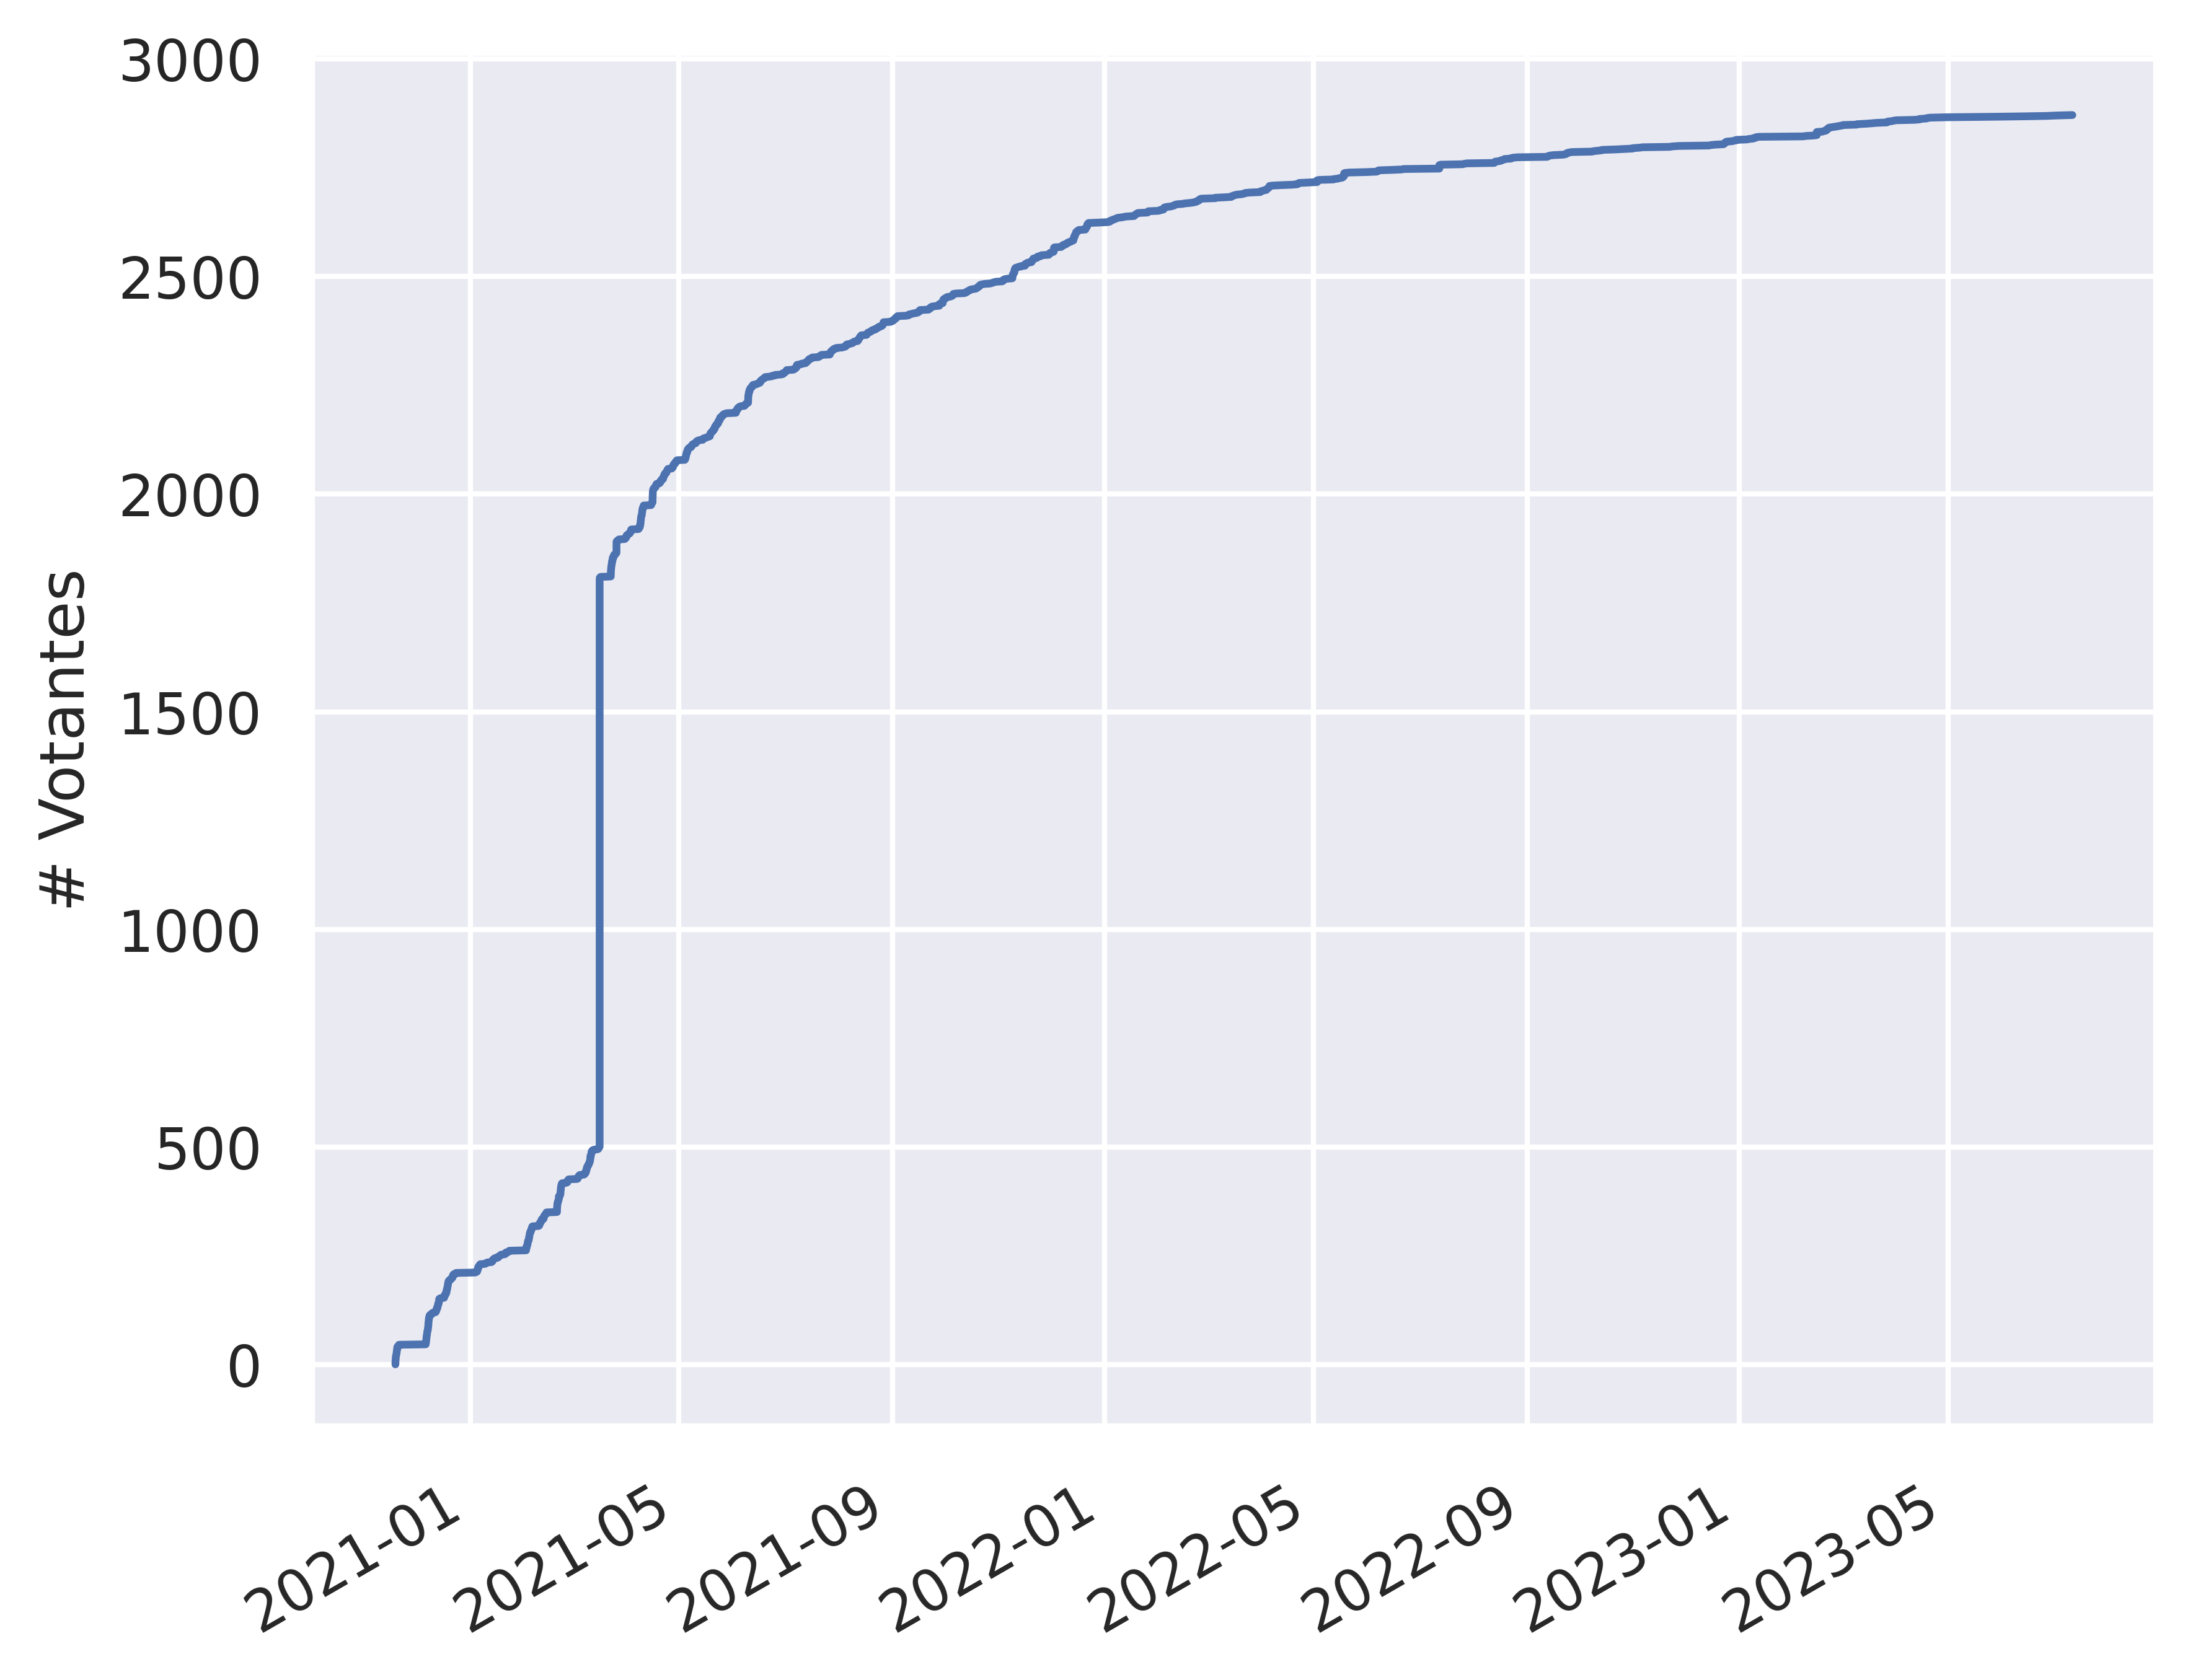

In [12]:
_toplot = dfv.groupby('voter')['date'].min()
_toplot = _toplot.sort_values().to_frame()
_toplot['cnt'] = 1
_toplot['cumcnt'] = _toplot['cnt'].cumsum()
ax = sns.lineplot(_toplot, x='date', y='cumcnt')
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# Votantes')

nbutils.download_matplotlib(ax.figure, f'04_hybrid_cumcnt_users_{ORG_NAME}.pdf')

## Cuando se crean las propuestas

Cannot show ipywidgets in text

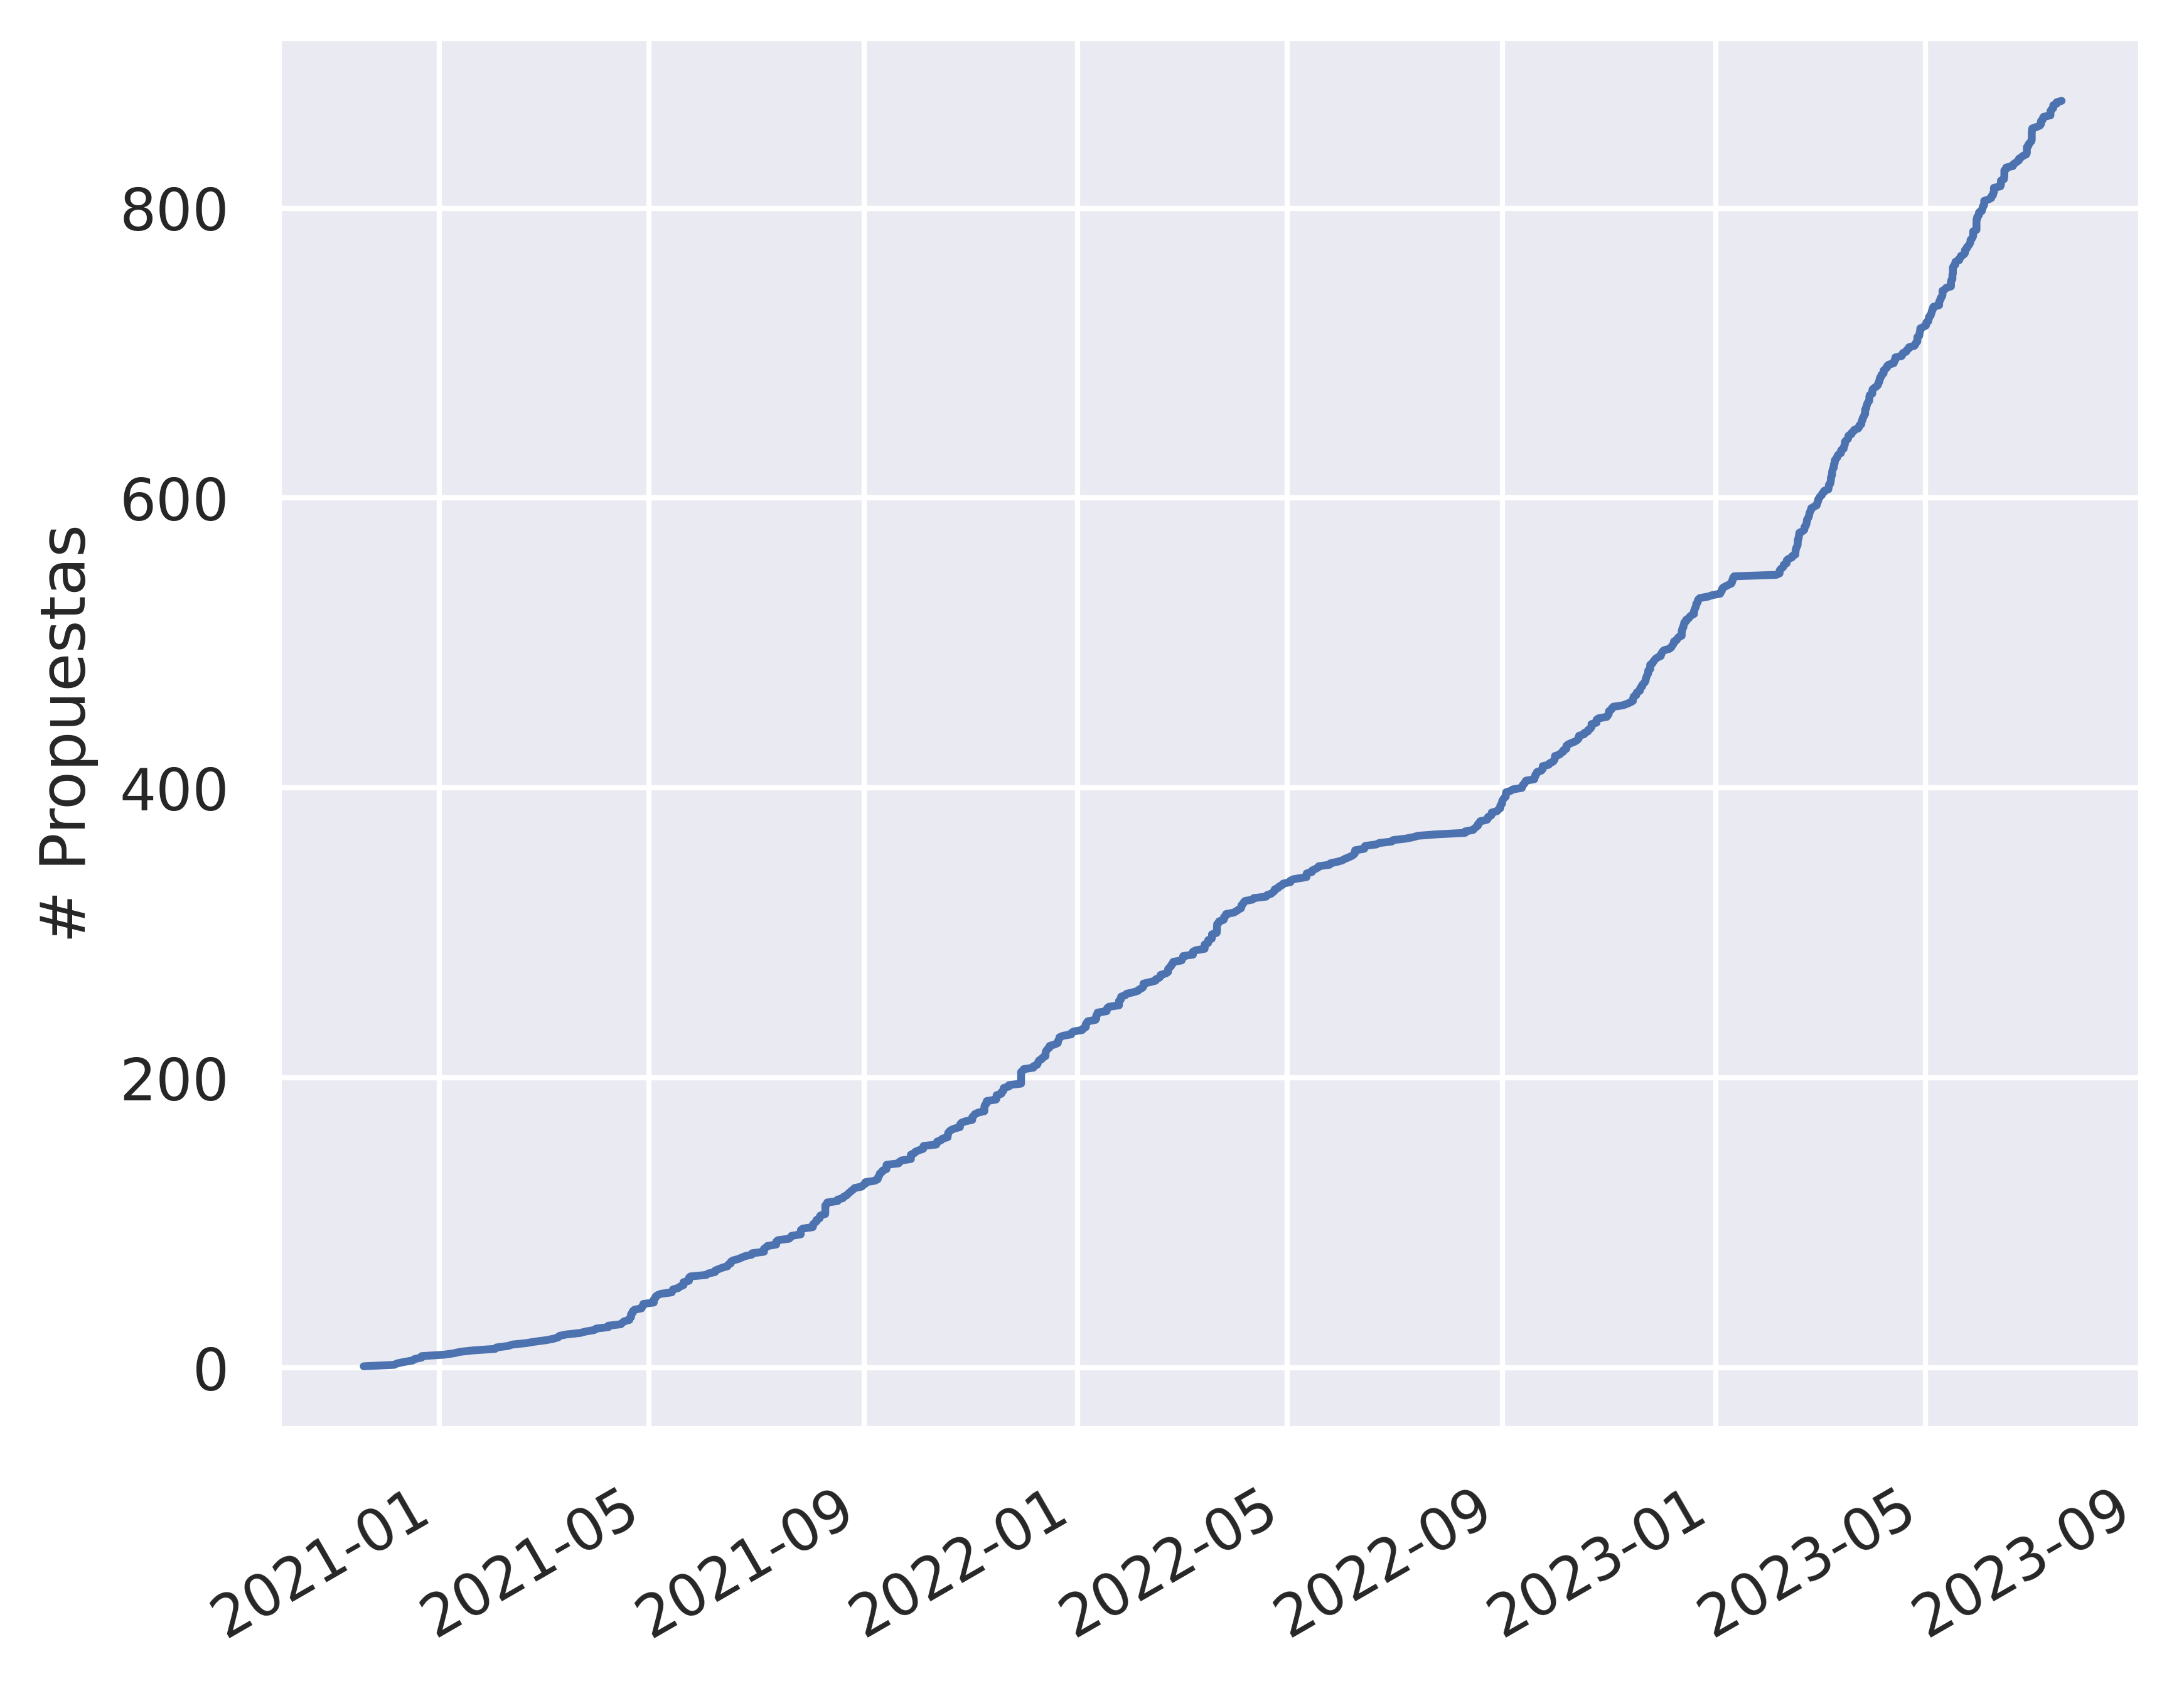

In [13]:
_toplot = dfv.groupby('proposal')['date'].min()
_toplot = _toplot.sort_values().to_frame()
_toplot['cnt'] = 1
_toplot['cumcnt'] = _toplot['cnt'].cumsum()
ax = sns.lineplot(_toplot, x='date', y='cumcnt')
plt.xticks(rotation=30, ha='right')
plt.xlabel('')
plt.ylabel('# Propuestas')

nbutils.download_matplotlib(ax.figure, f'04c_cumcnt_users_{ORG_NAME}.pdf')

Cannot show ipywidgets in text

<Figure size 3840x2880 with 0 Axes>

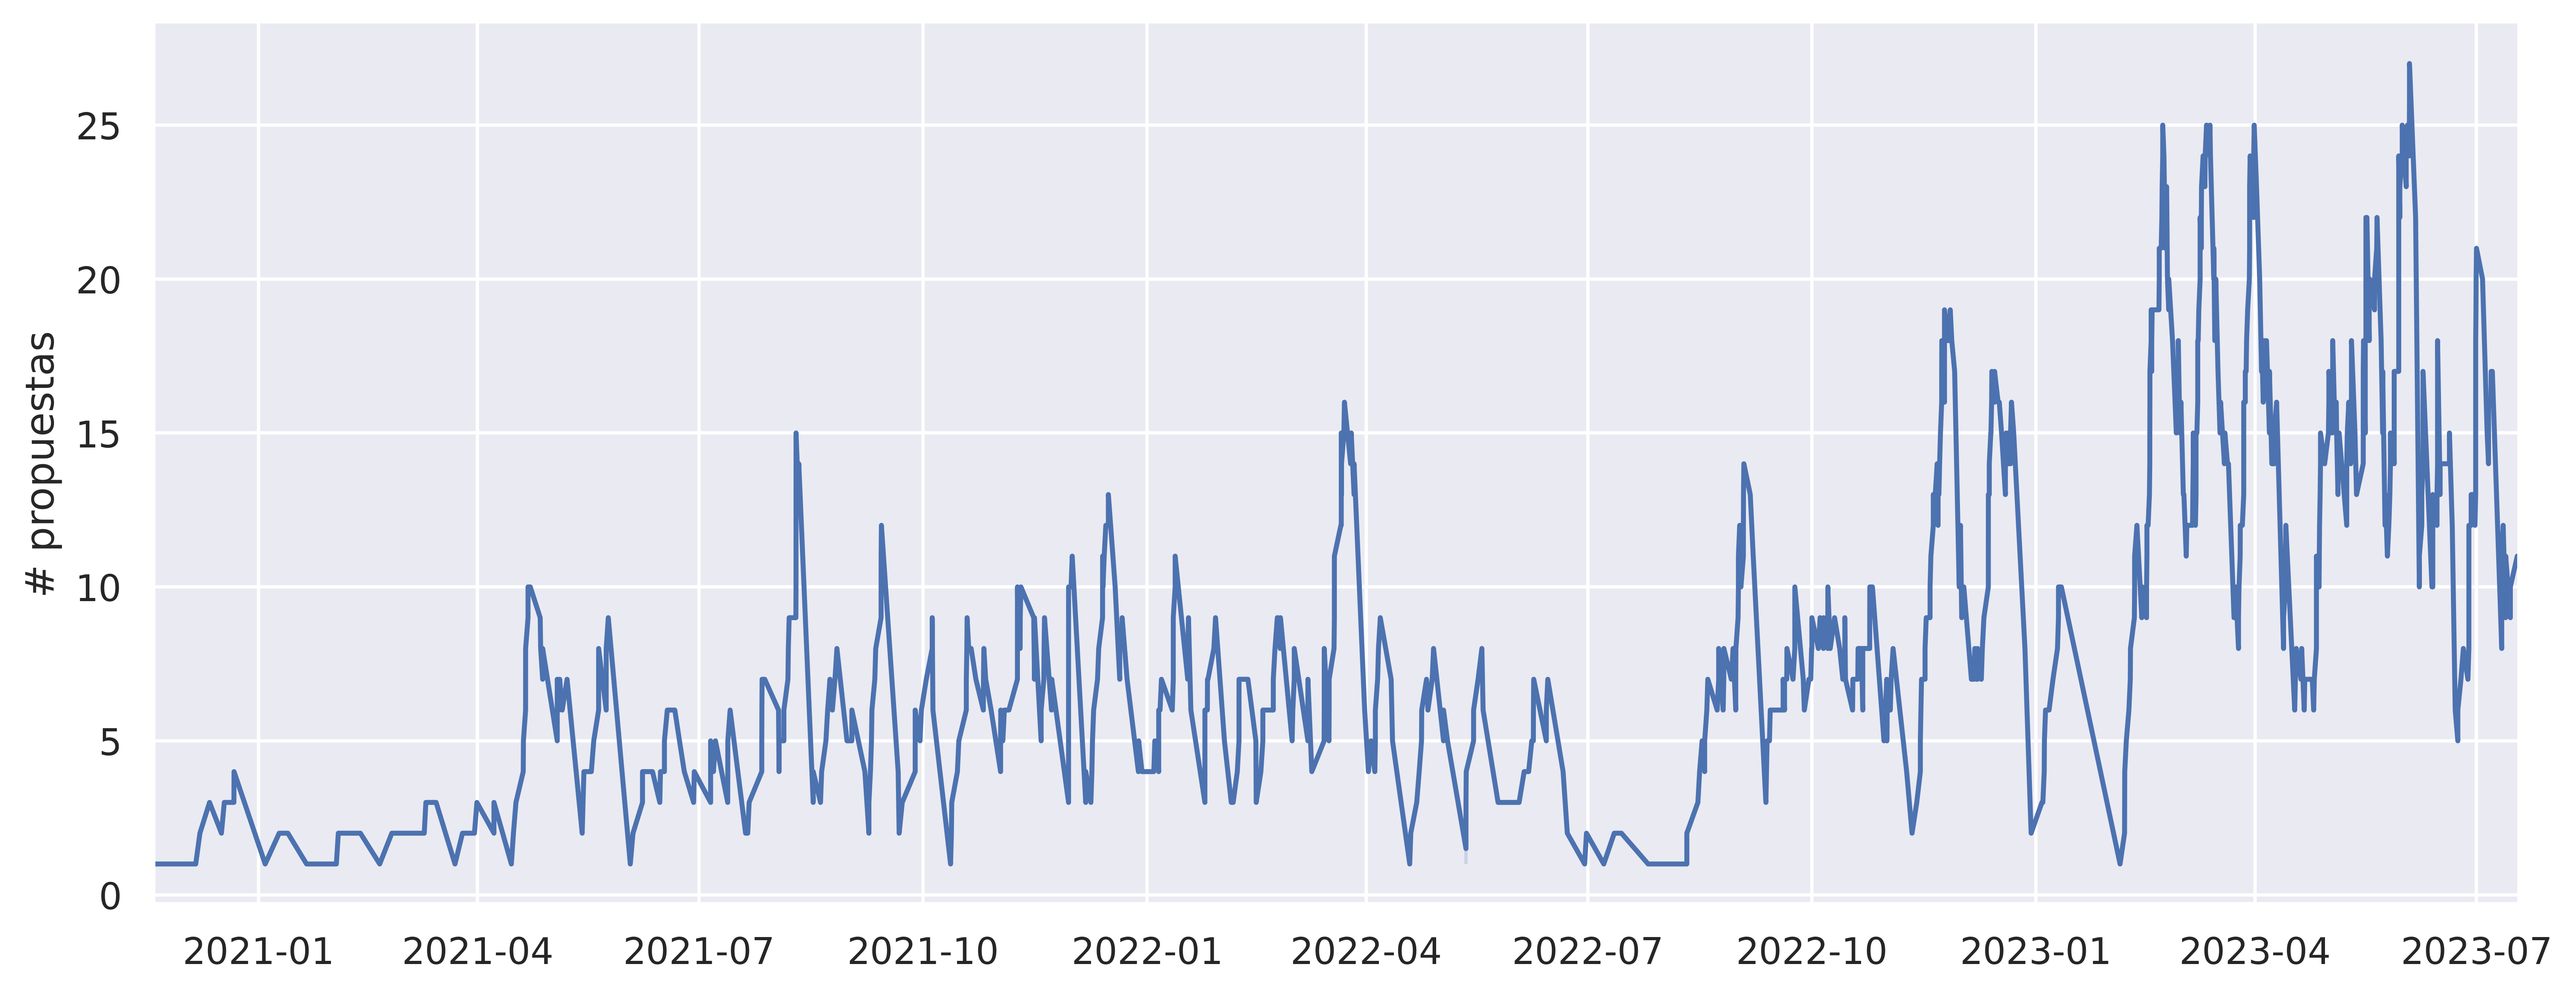

In [14]:
WINDOW_SIZE = '7D'

_toplot = dfv.groupby('proposal')['date'].min().sort_values()
_toplot = _toplot.to_frame()
_toplot['cnt'] = 1
_toplot = _toplot.rolling(window=WINDOW_SIZE, on='date').count()

# Double the width of the figure
fs = plt.gcf().get_size_inches()
plt.figure(figsize=(fs[0]*2, fs[1]))
# _toplot.set_index('date')['cnt'].plot()
ax = sns.lineplot(_toplot.set_index('date')['cnt'])

plt.xlabel('')
plt.ylabel('# propuestas')
plt.xlim(
    _toplot['date'].min(),
    _toplot['date'].max(),
)

sns.despine()
nbutils.download_matplotlib(ax.figure, f'04c_rolling_proposals_{WINDOW_SIZE}_{ORG_NAME}.pdf')

## Dia de la semana en que se votan las propuestas

> incluso, se podría hacer un heatmap X cuando se lanzan Y cuando se votan y Z (color) la frecuencia
> -- Javi

Vamos, que en esta celda vamos a intentar hacer un HEATMAP donde:
- X: dia de la semana de creación de la propuesta
- Y: dia de la semana de votación
- Z: número de votos

In [15]:
_toplot.to_numpy()

array([[Timestamp('2020-11-18 20:56:32'), 1.0],
       [Timestamp('2020-12-06 06:35:07'), 1.0],
       [Timestamp('2020-12-07 23:55:16'), 2.0],
       ...,
       [Timestamp('2023-07-14 21:54:35'), 9.0],
       [Timestamp('2023-07-14 21:54:49'), 10.0],
       [Timestamp('2023-07-17 18:00:14'), 11.0]], dtype=object)

Text(277.49999999999994, 0.5, 'Día votación')

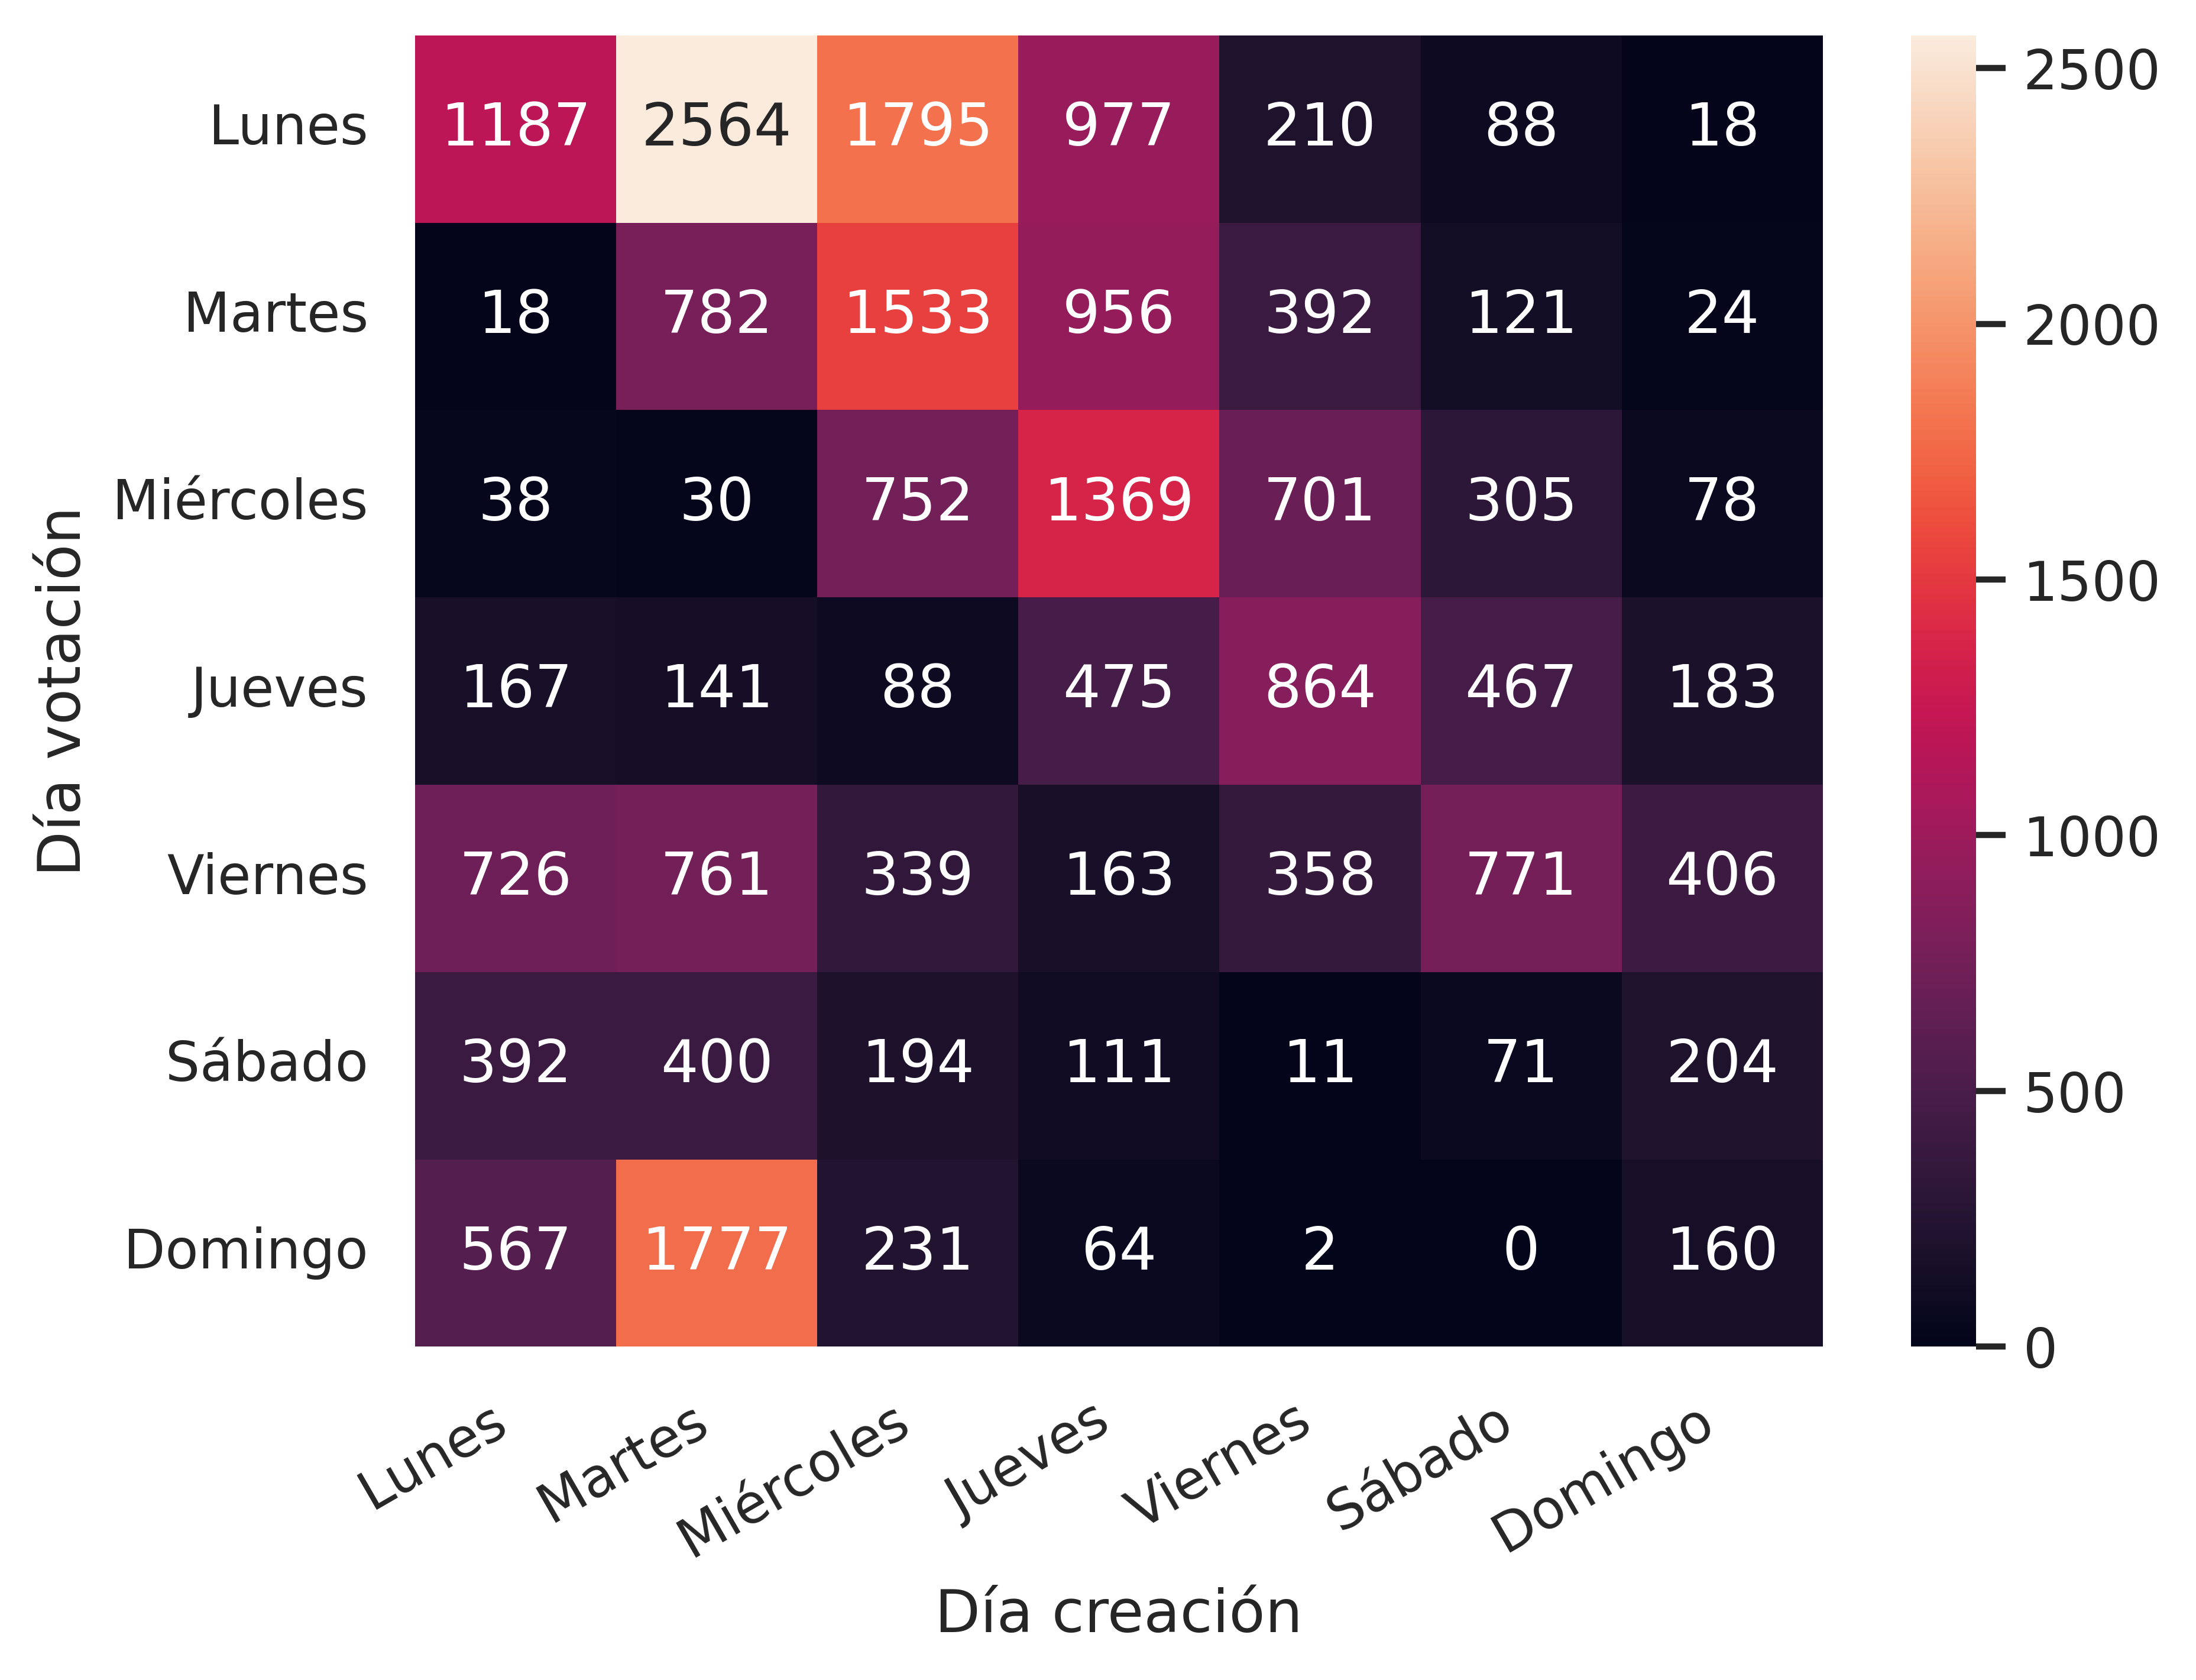

In [16]:
# In pandas, 0 = Monday
# https://pandas.pydata.org/docs/reference/api/pandas.Series.dt.dayofweek.html

spanish_dow = {
    0: 'Lunes',
    1: 'Martes',
    2: 'Miércoles',
    3: 'Jueves',
    4: 'Viernes', 
    5: 'Sábado',
    6: 'Domingo',
}

_dfvp = dfv.merge(dfp['date'].rename('proposal_date'), left_on='proposal', right_index=True)
_dfvp['date_dow'] = _dfvp['date'].dt.day_of_week
_dfvp['proposal_date_dow'] = _dfvp['proposal_date'].dt.dayofweek
# sns.load_dataset("glue").pivot(index="Model", columns="Task", values="Score")
_toplot = pd.crosstab(_dfvp['proposal_date_dow'], _dfvp['date_dow']).rename(index=spanish_dow, columns=spanish_dow)

sns.heatmap(_toplot, annot=True, fmt='g')
plt.xticks(rotation=30, ha='right')

plt.xlabel('Día creación')
plt.ylabel('Día votación')

Cannot show ipywidgets in text

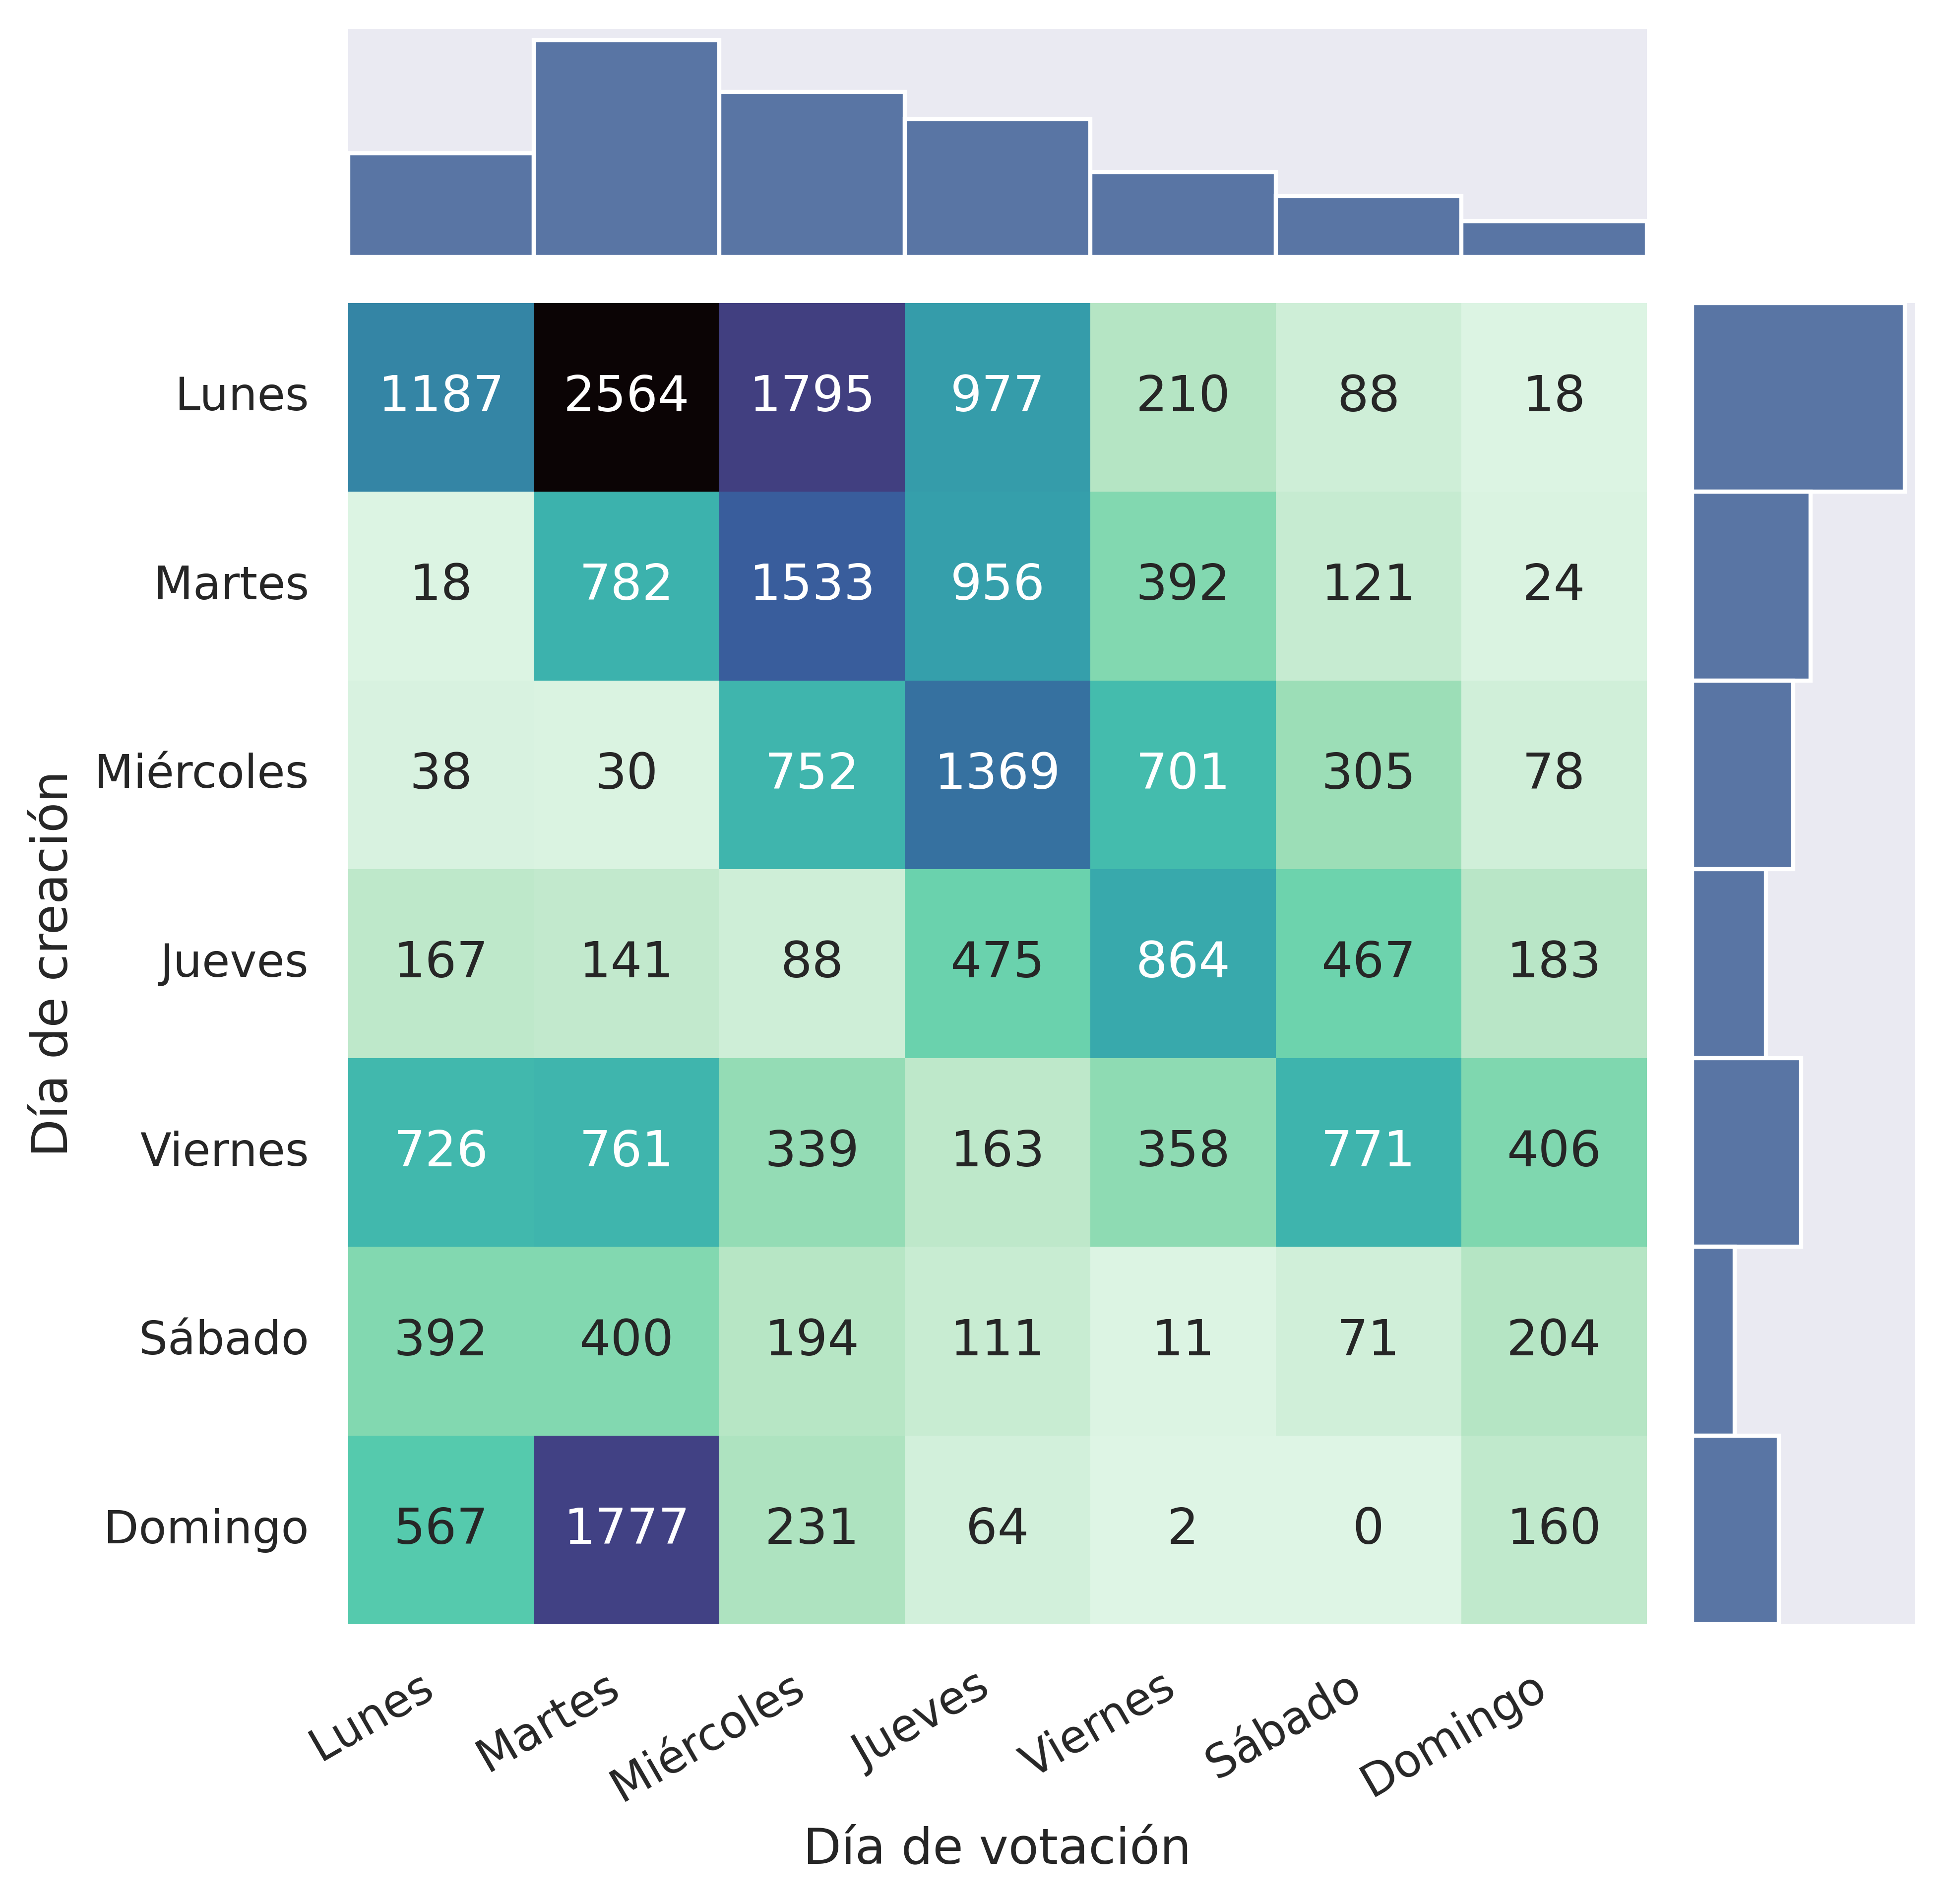

In [17]:
# _toplot = pd.crosstab(...)

grid = sns.JointGrid()

sns.heatmap(_toplot, ax=grid.ax_joint, cbar=False, annot=True, fmt='g', cmap='mako_r')
sns.barplot(_toplot.sum(), ax=grid.ax_marg_x, width=1)
sns.barplot(_toplot.sum(axis=1), ax=grid.ax_marg_y, orient='h', width=1)
_off = .5

# Fix x
_xmin, _xmax = grid.ax_joint.get_xlim()
grid.ax_joint.set_xlim(_xmin+_off, _xmax+_off)
for bar in grid.ax_marg_x.containers[0]:
    bar.set_x(bar.get_x() + _off)

# Fix y
_ymin, _ymax = grid.ax_joint.get_ylim()
grid.ax_joint.set_ylim(_ymin+_off, _ymax+_off)
for bar in grid.ax_marg_y.containers[0]:
    bar.set_y(bar.get_y() + _off)

grid.ax_joint.set_xticklabels(grid.ax_joint.get_xticklabels(), rotation=30, ha='right')
grid.ax_joint.yaxis.set_tick_params(rotation=0)

grid.ax_joint.set_xlabel('Día de votación')
grid.ax_joint.set_ylabel('Día de creación')

nbutils.download_matplotlib(grid, f'04c_heatmap_proposals_{ORG_NAME}.pdf')

<Axes: xlabel='proposal_date_dow', ylabel='count'>

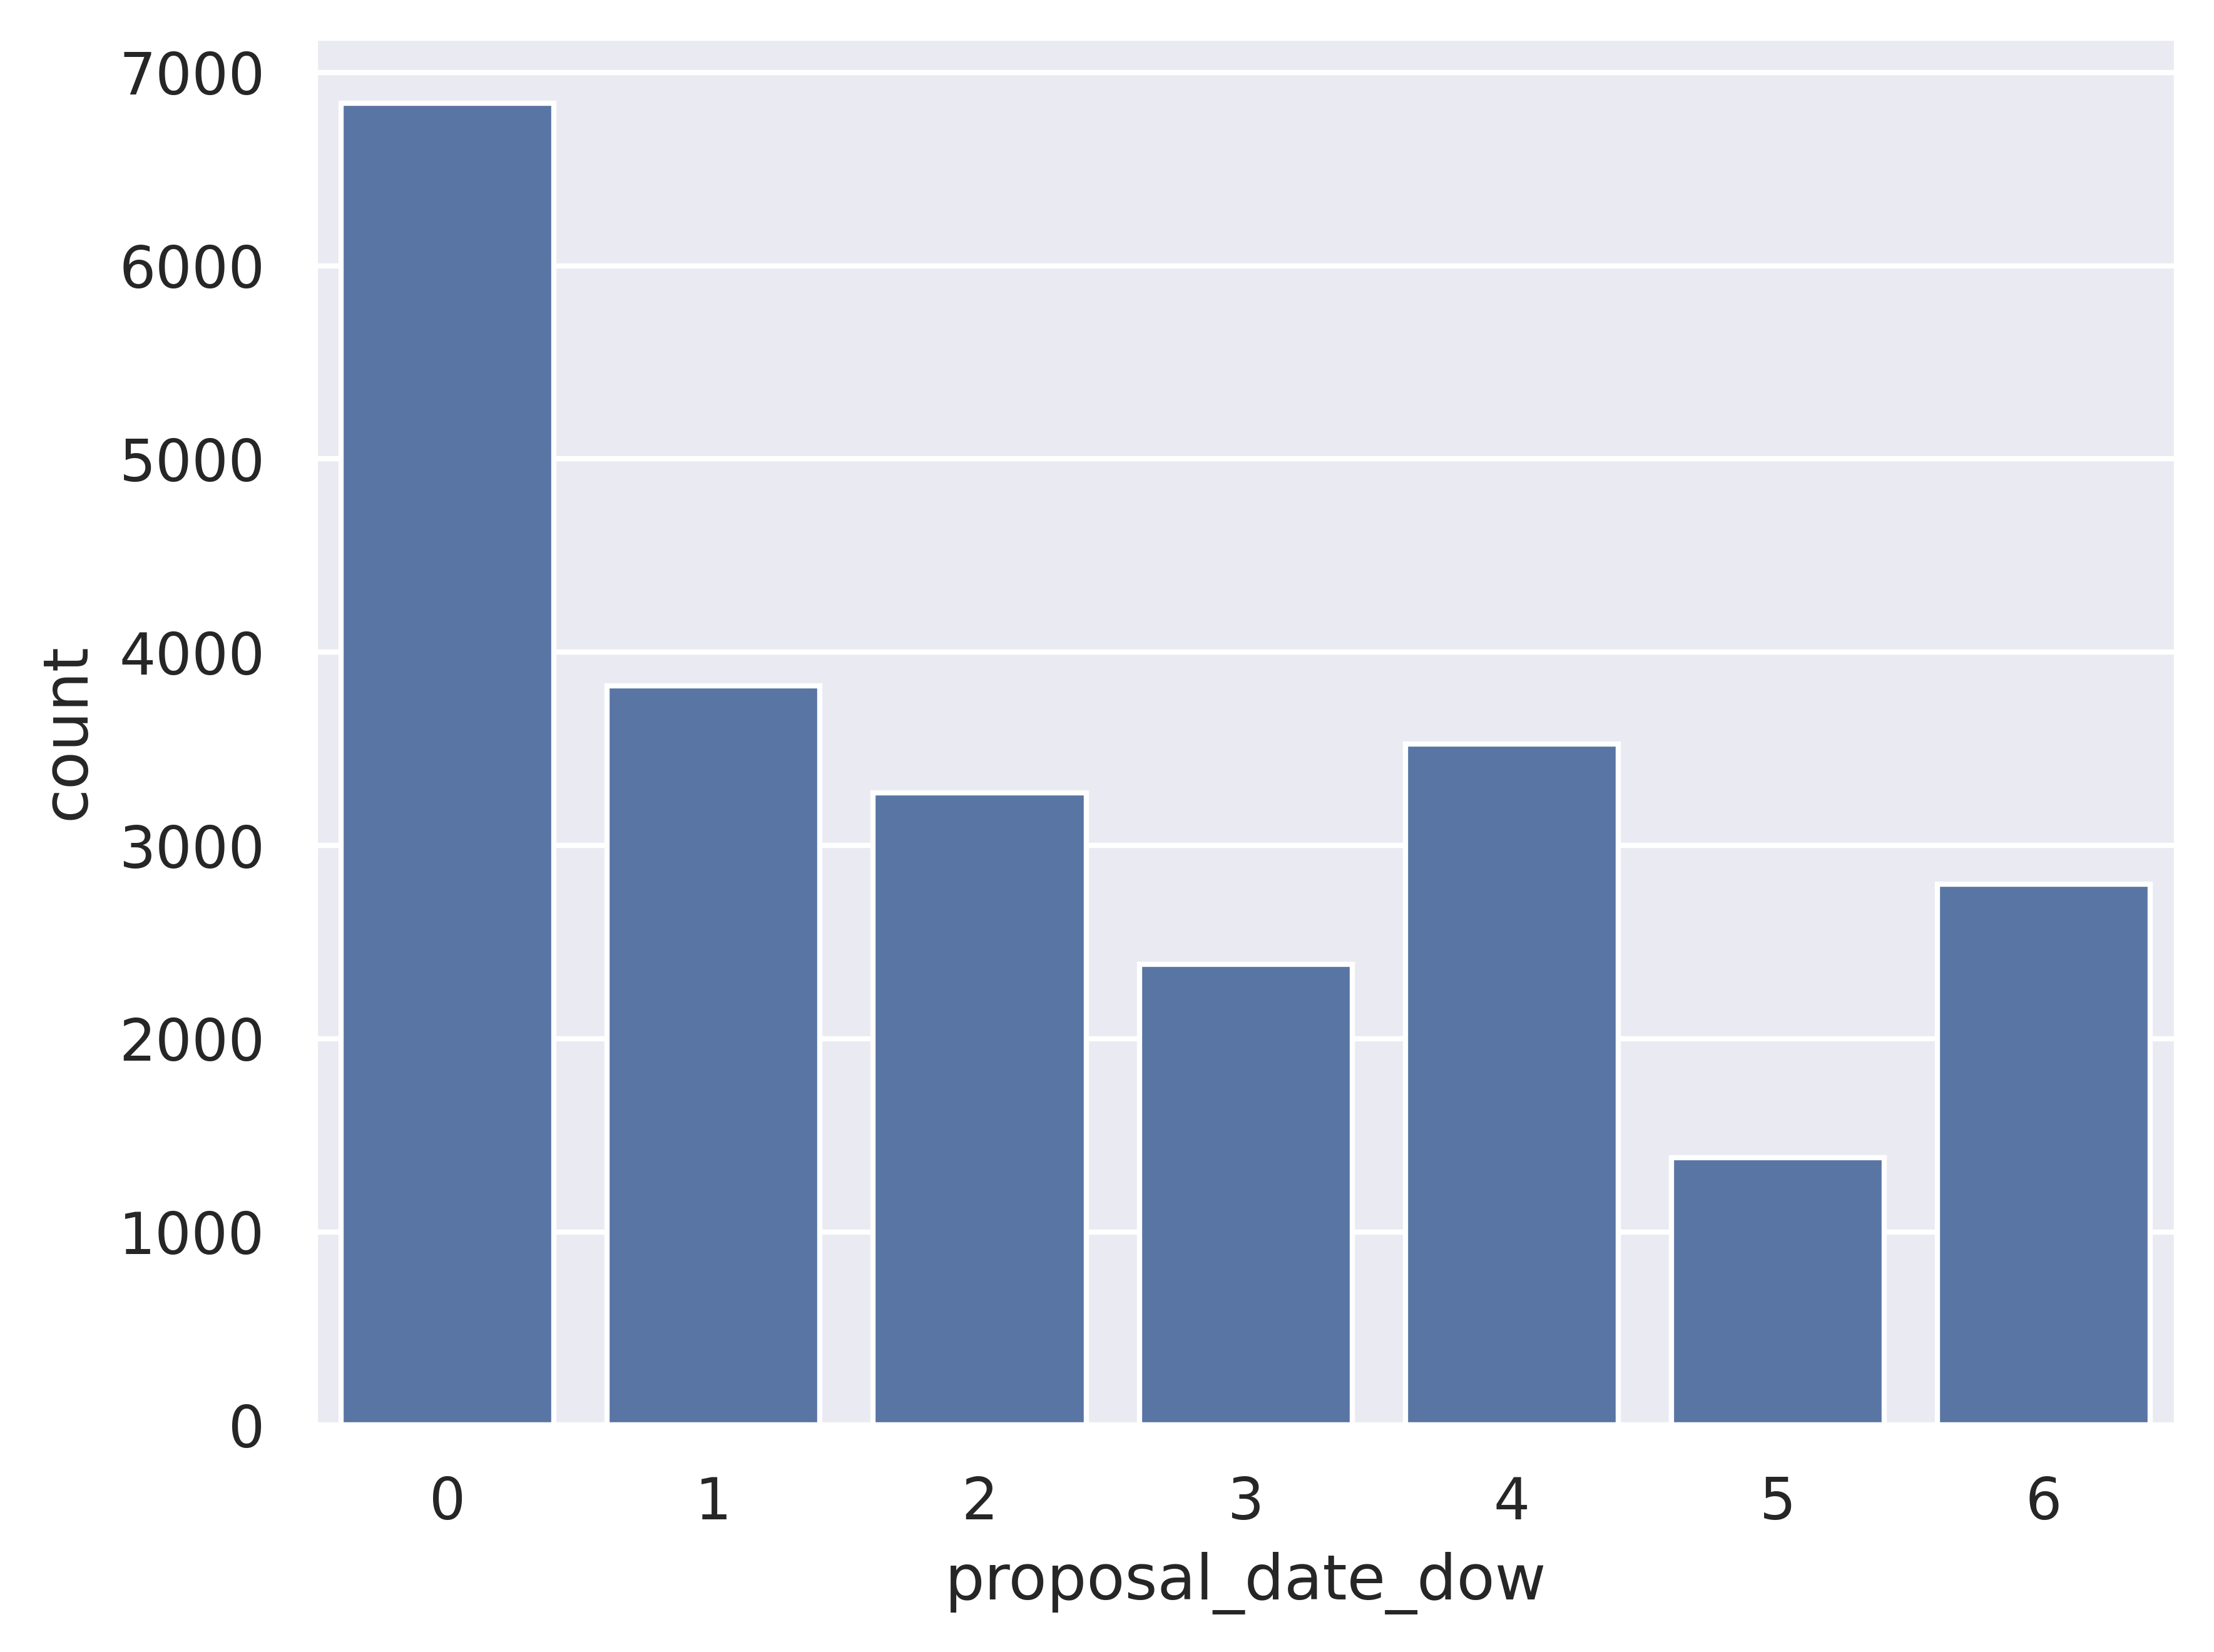

In [18]:
sns.countplot(_dfvp, x='proposal_date_dow')

<Axes: xlabel='count', ylabel='date_dow'>

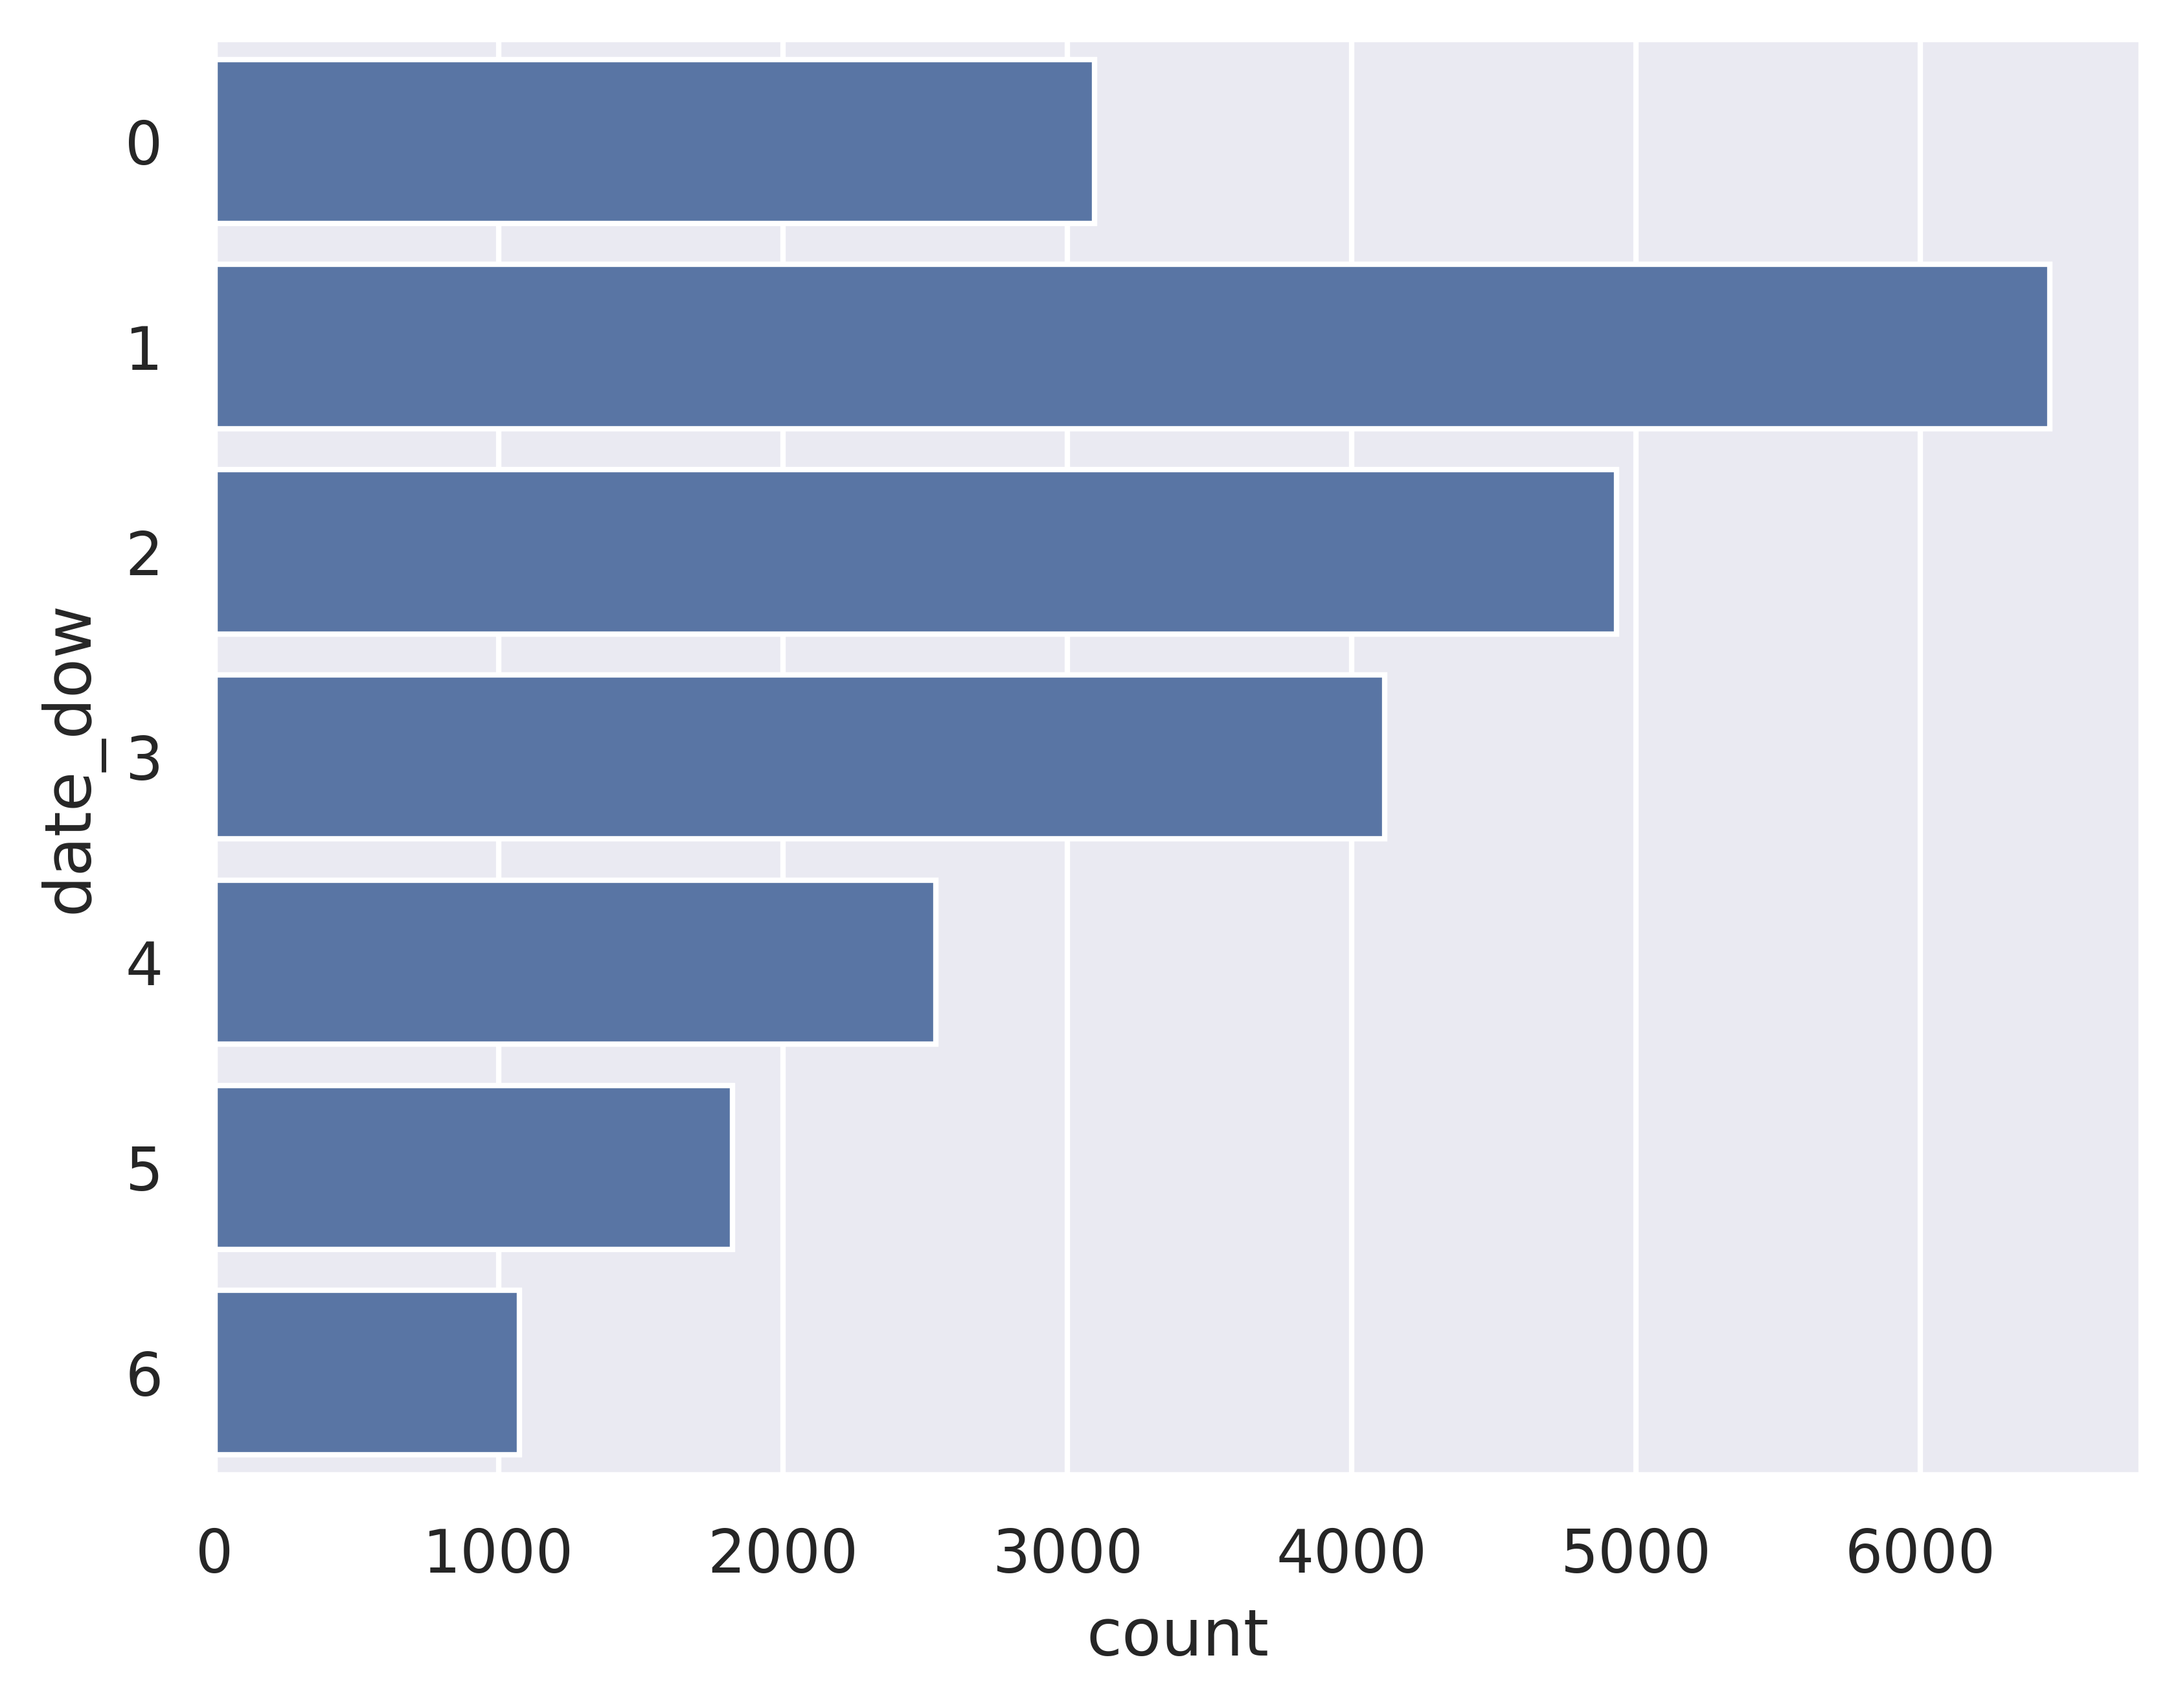

In [19]:
sns.countplot(_dfvp, y='date_dow')

## Suelen votarse las propuestas al principio o al final

In [20]:
def proposal_histogram(proposal):
    p = dfp.loc[proposal]
    _aux = dfv[dfv["proposal"] == proposal][['platform', 'name', 'date']].copy().sort_values('date')
    first_vote = p['start']
    last_vote = p['end']
    print(p['start'], p['end'], p['end'] - p['start'])
    _aux['date_rel'] = (_aux['date'] - p['start']) / (p['end'] - p['start'])
    # sns.ecdfplot(_aux['date_rel'])
    ax = sns.histplot(_aux['date_rel'])
    ax.set_title(f"Histograma de tiempo de los votos en la propuesta {proposal}")
    return ax

# proposal_histogram(proposal = "b86aa059-3d31-5d41-a472-70962816f779")

## Ahora para TODOS los votos

Cuidado que este grafo puede estar sesgado por una sola propuesta

In [21]:
dfp

platform        name  \
id                                                           
e2b5bee1-71b4-50f9-ad3e-7f3658ab7bfb  snapshot  Index Coop   
b4c04927-7699-540e-9dff-4450a654499e  snapshot  Index Coop   
b9253e53-cc59-5631-9416-d409ca40519b  snapshot  Index Coop   
b30de8f6-ce54-55d0-9283-4320b5e73e27  snapshot  Index Coop   
11547946-98f4-51e2-b6cc-5753d1699e88  snapshot  Index Coop   
...                                        ...         ...   
c6b70884-c448-5151-be60-2a9268314925  snapshot  Index Coop   
7501bcaa-f72e-570c-afcb-b30172367227  snapshot  Index Coop   
4476d65d-b6de-505e-9f07-5b8f63f01ffd  snapshot  Index Coop   
4ab7a371-ab27-5f9a-8928-850b9a0415d6  snapshot  Index Coop   
ebe47c59-d740-5459-b69f-e076f43209b5  snapshot  Index Coop   

                                     platform_deployment  \
id                                                         
e2b5bee1-71b4-50f9-ad3e-7f3658ab7bfb      index-coop.eth   
b4c04927-7699-540e-9dff-4450a654499e      index-coop.eth   
b9253e53-cc59-5631-9416-d409ca40519b      index-coop.eth   
b30de8f6-ce54-55d0-9283-4320b5e73e27      index-coop.eth   
11547946-98f4-51e2-b6cc-5753d1699e88      index-coop.eth   
...                                                  ...   
c6b70884-c448-5151-be60-2a9268314925      index-coop.eth   
7501bcaa-f72e-570c-afcb-b30172367227      index-coop.eth   
4476d65d-b6de-505e-9f07-5b8f63f01ffd      index-coop.eth   
4ab7a371-ab27-5f9a-8928-850b9a0415d6      index-coop.eth   
ebe47c59-d740-5459-b69f-e076f43209b5      index-coop.eth   

                                                                deployment  \
id                                                                           
e2b5bee1-71b4-50f9-ad3e-7f3658ab7bfb  17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb   
b4c04927-7699-540e-9dff-4450a654499e  17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb   
b9253e53-cc59-5631-9416-d409ca40519b  17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb   
b30de8f6-ce54-55d0-9283-4320b5e73e27  17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb   
11547946-98f4-51e2-b6cc-5753d1699e88  17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb   
...                                                                    ...   
c6b70884-c448-5151-be60-2a9268314925  17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb   
7501bcaa-f72e-570c-afcb-b30172367227  17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb   
4476d65d-b6de-505e-9f07-5b8f63f01ffd  17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb   
4ab7a371-ab27-5f9a-8928-850b9a0415d6  17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb   
ebe47c59-d740-5459-b69f-e076f43209b5  17dba91a-e68f-50f6-8c1d-2d7fa57ab5fb   

                                                                      platform_proposal  \
id                                                                                        
e2b5bee1-71b4-50f9-ad3e-7f3658ab7bfb     QmUPRoz427hLpG5kWvr18Aami3eywQnais5jX22JbdUYys   
b4c04927-7699-540e-9dff-4450a654499e     QmZuFFVjTSboPHR7DRHmJ4uqXW1SEUPWE53aMwZ5M55rQq   
b9253e53-cc59-5631-9416-d409ca40519b     QmaikKf56LASjR6VoyJ3Q4aGwUHJcsuWrkEA2sQVNyaHAy   
b30de8f6-ce54-55d0-9283-4320b5e73e27     QmPC98CVvLXyB6r1eF6KD2kjfGwgsUPUJEPfpvVJZaY7xK   
11547946-98f4-51e2-b6cc-5753d1699e88     QmTYSEAYEmr9VFYgB9AoHbDD898nxsCgdoSg8fDSxLBkqW   
...                                                                                 ...   
c6b70884-c448-5151-be60-2a9268314925  0x8a65889ac28a149fd690cf7c2a49a8f81015279821f8...   
7501bcaa-f72e-570c-afcb-b30172367227  0x78f4522c15368175632f84ac8b1111ab13c14bb960be...   
4476d65d-b6de-505e-9f07-5b8f63f01ffd  0xb54d6a644ce5546234a11dbe559401e245336cbc46a2...   
4ab7a371-ab27-5f9a-8928-850b9a0415d6  0x1e3d487574213b6cc4b94fdaa75da4726cd8d228c8fa...   
ebe47c59-d740-5459-b69f-e076f43209b5  0xa722ab9d2e4a6791c062fabdfdf044de427a61fc9dd0...   

                                                                          author  \
id                                                                                 
e2b5bee1-71b4-50f9-ad3e-7f3658ab7bfb  0xc2971fe806ce4438da09e21fc7be7fb121cf7e13   

Text(0.5, 1.0, 'Histograma de todos los votos realizados en Index Coop')

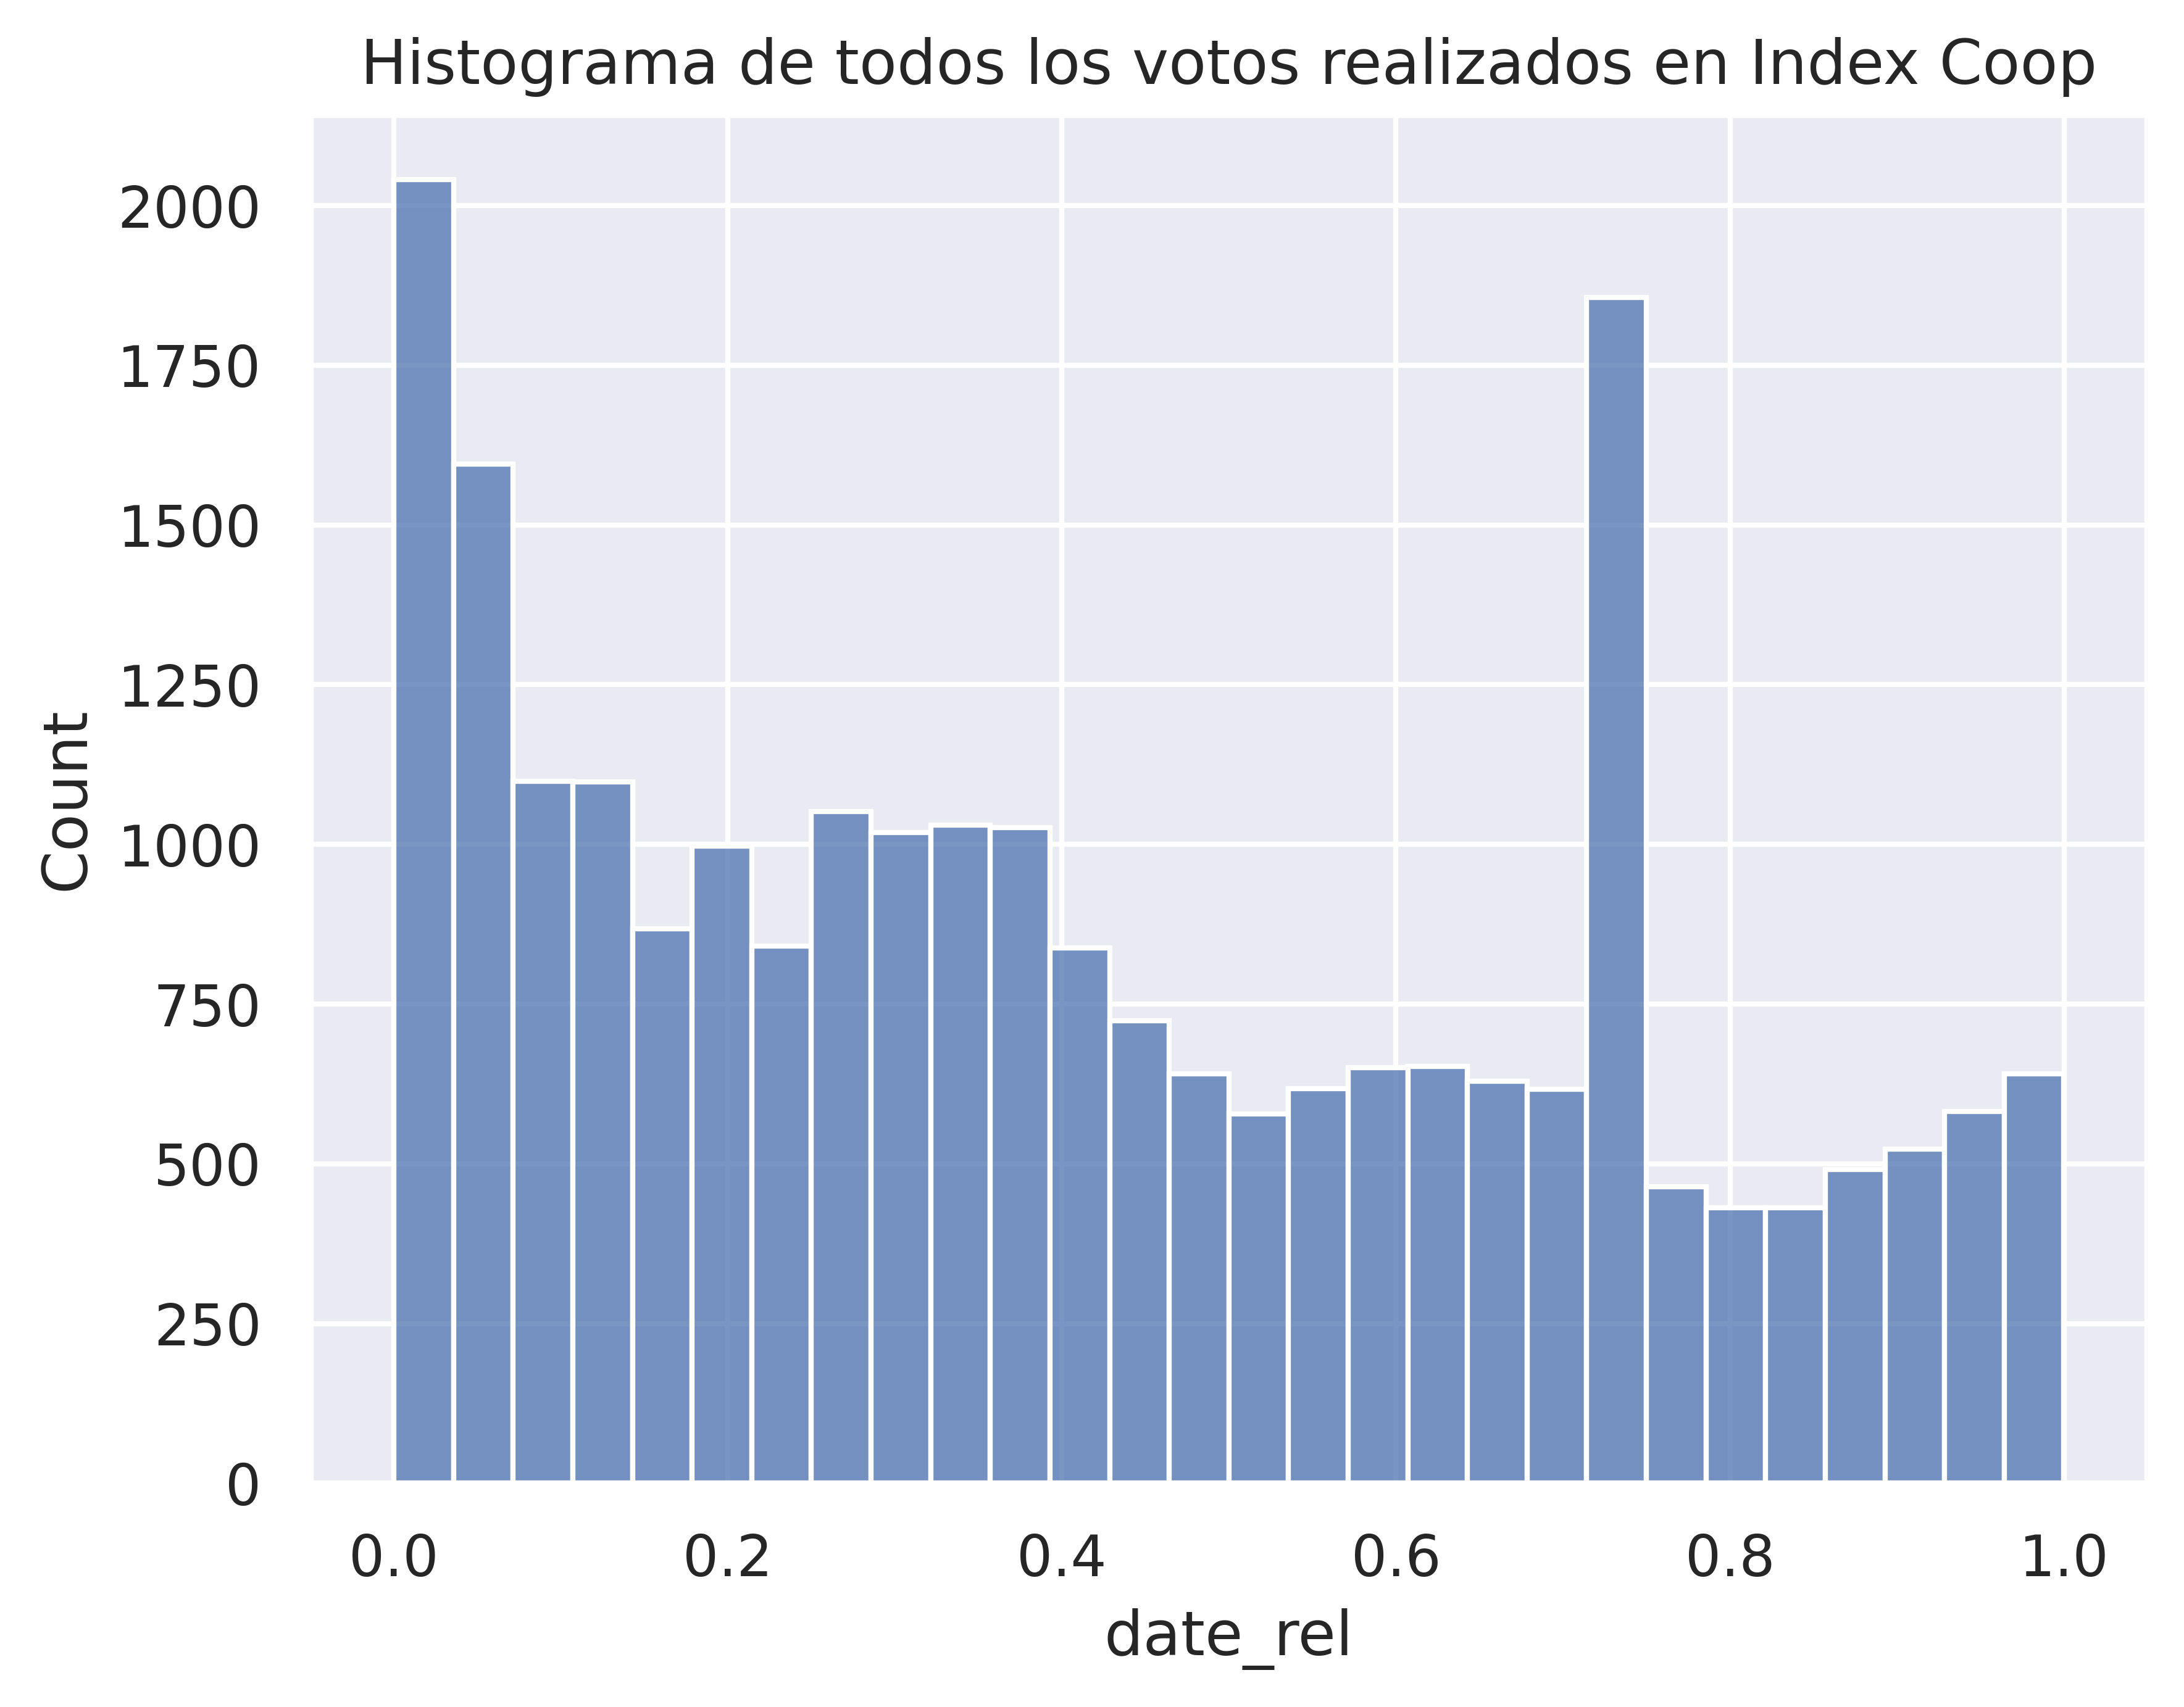

In [22]:
_dfv = dfv[['platform', 'name', 'proposal', 'date']].merge(dfp[['start', 'end']], left_on='proposal', right_index=True).sort_values('date')
_dfv['date_rel'] = (_dfv['date'] - _dfv['start']) / (_dfv['end'] - _dfv['start'])
ax = sns.histplot(_dfv, x='date_rel')
ax.set_title(f"Histograma de todos los votos realizados en {ORG_NAME}")

In [23]:
_dfv[['date_rel']].describe(percentiles=[.1,.25,.5,.75,.78,.8])

date_rel
count  24031.000000
mean       0.413878
std        0.292361
min        0.000046
10%        0.042577
25%        0.150336
50%        0.369544
75%        0.680035
78%        0.715356
80%        0.715796
max        0.999888

### Cuando son los votos (histograma distribución en tiempo de TODOS los votos)

Vamos a intentar calcular la frecuencia relativa acumulada

In [24]:
rel = (1 / _dfv.groupby('proposal').size()).rename('freq')
_dfv2 = _dfv.join(rel, on='proposal')
_dfv2['cumfreq'] = _dfv2.groupby('proposal')['freq'].cumsum()
_dfv2

platform        name                              proposal  \
9824  snapshot  Index Coop  e03585d8-6ab1-52d0-8d05-6b20a2f457b9   
9823  snapshot  Index Coop  e03585d8-6ab1-52d0-8d05-6b20a2f457b9   
9822  snapshot  Index Coop  e03585d8-6ab1-52d0-8d05-6b20a2f457b9   
9821  snapshot  Index Coop  e03585d8-6ab1-52d0-8d05-6b20a2f457b9   
9820  snapshot  Index Coop  e03585d8-6ab1-52d0-8d05-6b20a2f457b9   
...        ...         ...                                   ...   
8632  snapshot  Index Coop  a3350420-69f0-5ca3-98a5-ebe60952bed1   
8631  snapshot  Index Coop  a3350420-69f0-5ca3-98a5-ebe60952bed1   
8630  snapshot  Index Coop  a3350420-69f0-5ca3-98a5-ebe60952bed1   
8629  snapshot  Index Coop  a3350420-69f0-5ca3-98a5-ebe60952bed1   
8628  snapshot  Index Coop  a3350420-69f0-5ca3-98a5-ebe60952bed1   

                    date               start                 end  date_rel  \
9824 2020-11-18 20:56:32 2020-11-18 16:00:00 2020-11-21 08:28:00  0.076663   
9823 2020-11-18 21:23:13 2020-11-18 16:00:00 2020-11-21 08:28:00  0.083562   
9822 2020-11-18 21:23:55 2020-11-18 16:00:00 2020-11-21 08:28:00  0.083743   
9821 2020-11-18 21:42:37 2020-11-18 16:00:00 2020-11-21 08:28:00  0.088577   
9820 2020-11-18 21:45:10 2020-11-18 16:00:00 2020-11-21 08:28:00  0.089236   
...                  ...                 ...                 ...       ...   
8632 2023-07-18 05:34:29 2023-07-17 16:44:05 2023-07-19 16:44:05  0.267500   
8631 2023-07-18 18:42:04 2023-07-17 16:44:05 2023-07-19 16:44:05  0.540966   
8630 2023-07-18 23:58:06 2023-07-17 16:44:05 2023-07-19 16:44:05  0.650700   
8629 2023-07-19 00:31:54 2023-07-17 16:44:05 2023-07-19 16:44:05  0.662436   
8628 2023-07-19 14:30:54 2023-07-17 16:44:05 2023-07-19 16:44:05  0.953756   

          freq   cumfreq  
9824  0.021739  0.021739  
9823  0.021739  0.043478  
9822  0.021739  0.065217  
9821  0.021739  0.086957  
9820  0.021739  0.108696  
...        ...       ...  
8632  0.142857  0.428571  
8631  0.142857  0.571429  
8630  0.142857  0.714286  
8629  0.142857  0.857143  
8628  0.142857  1.000000  

[24031 rows x 9 columns]

In [25]:
_dfv2.groupby('proposal').size().sort_values()

proposal
4ac837ee-91d6-5606-be77-be623b08ed4a       1
0cabb9ef-8b04-5b58-b523-06de86a3dd17       1
6fc0eaba-2cca-5f4e-b85d-ab4d085fa60f       1
c995ff05-d9e6-55e4-9cb5-6d5f16527183       1
dd041fd6-8ae6-51a5-aaff-47e0e04fb120       1
                                        ... 
55770530-f288-5adb-a269-a235b3f7c1ff     149
56a4f0ee-04a2-5c7d-ab73-69fa6a0ab7c8     153
dcf7b67e-5237-54d8-9177-ba1ca82654ee     163
5d069417-d6e0-55cd-9efb-d29c5436d990     169
e216cd59-3195-5a70-a022-357dd80969c1    1367
Length: 874, dtype: int64


### KDE plot de las más votadas

Text(0.5, 1.0, 'kde plot de las 15 propuestas más grandes en Index Coop')

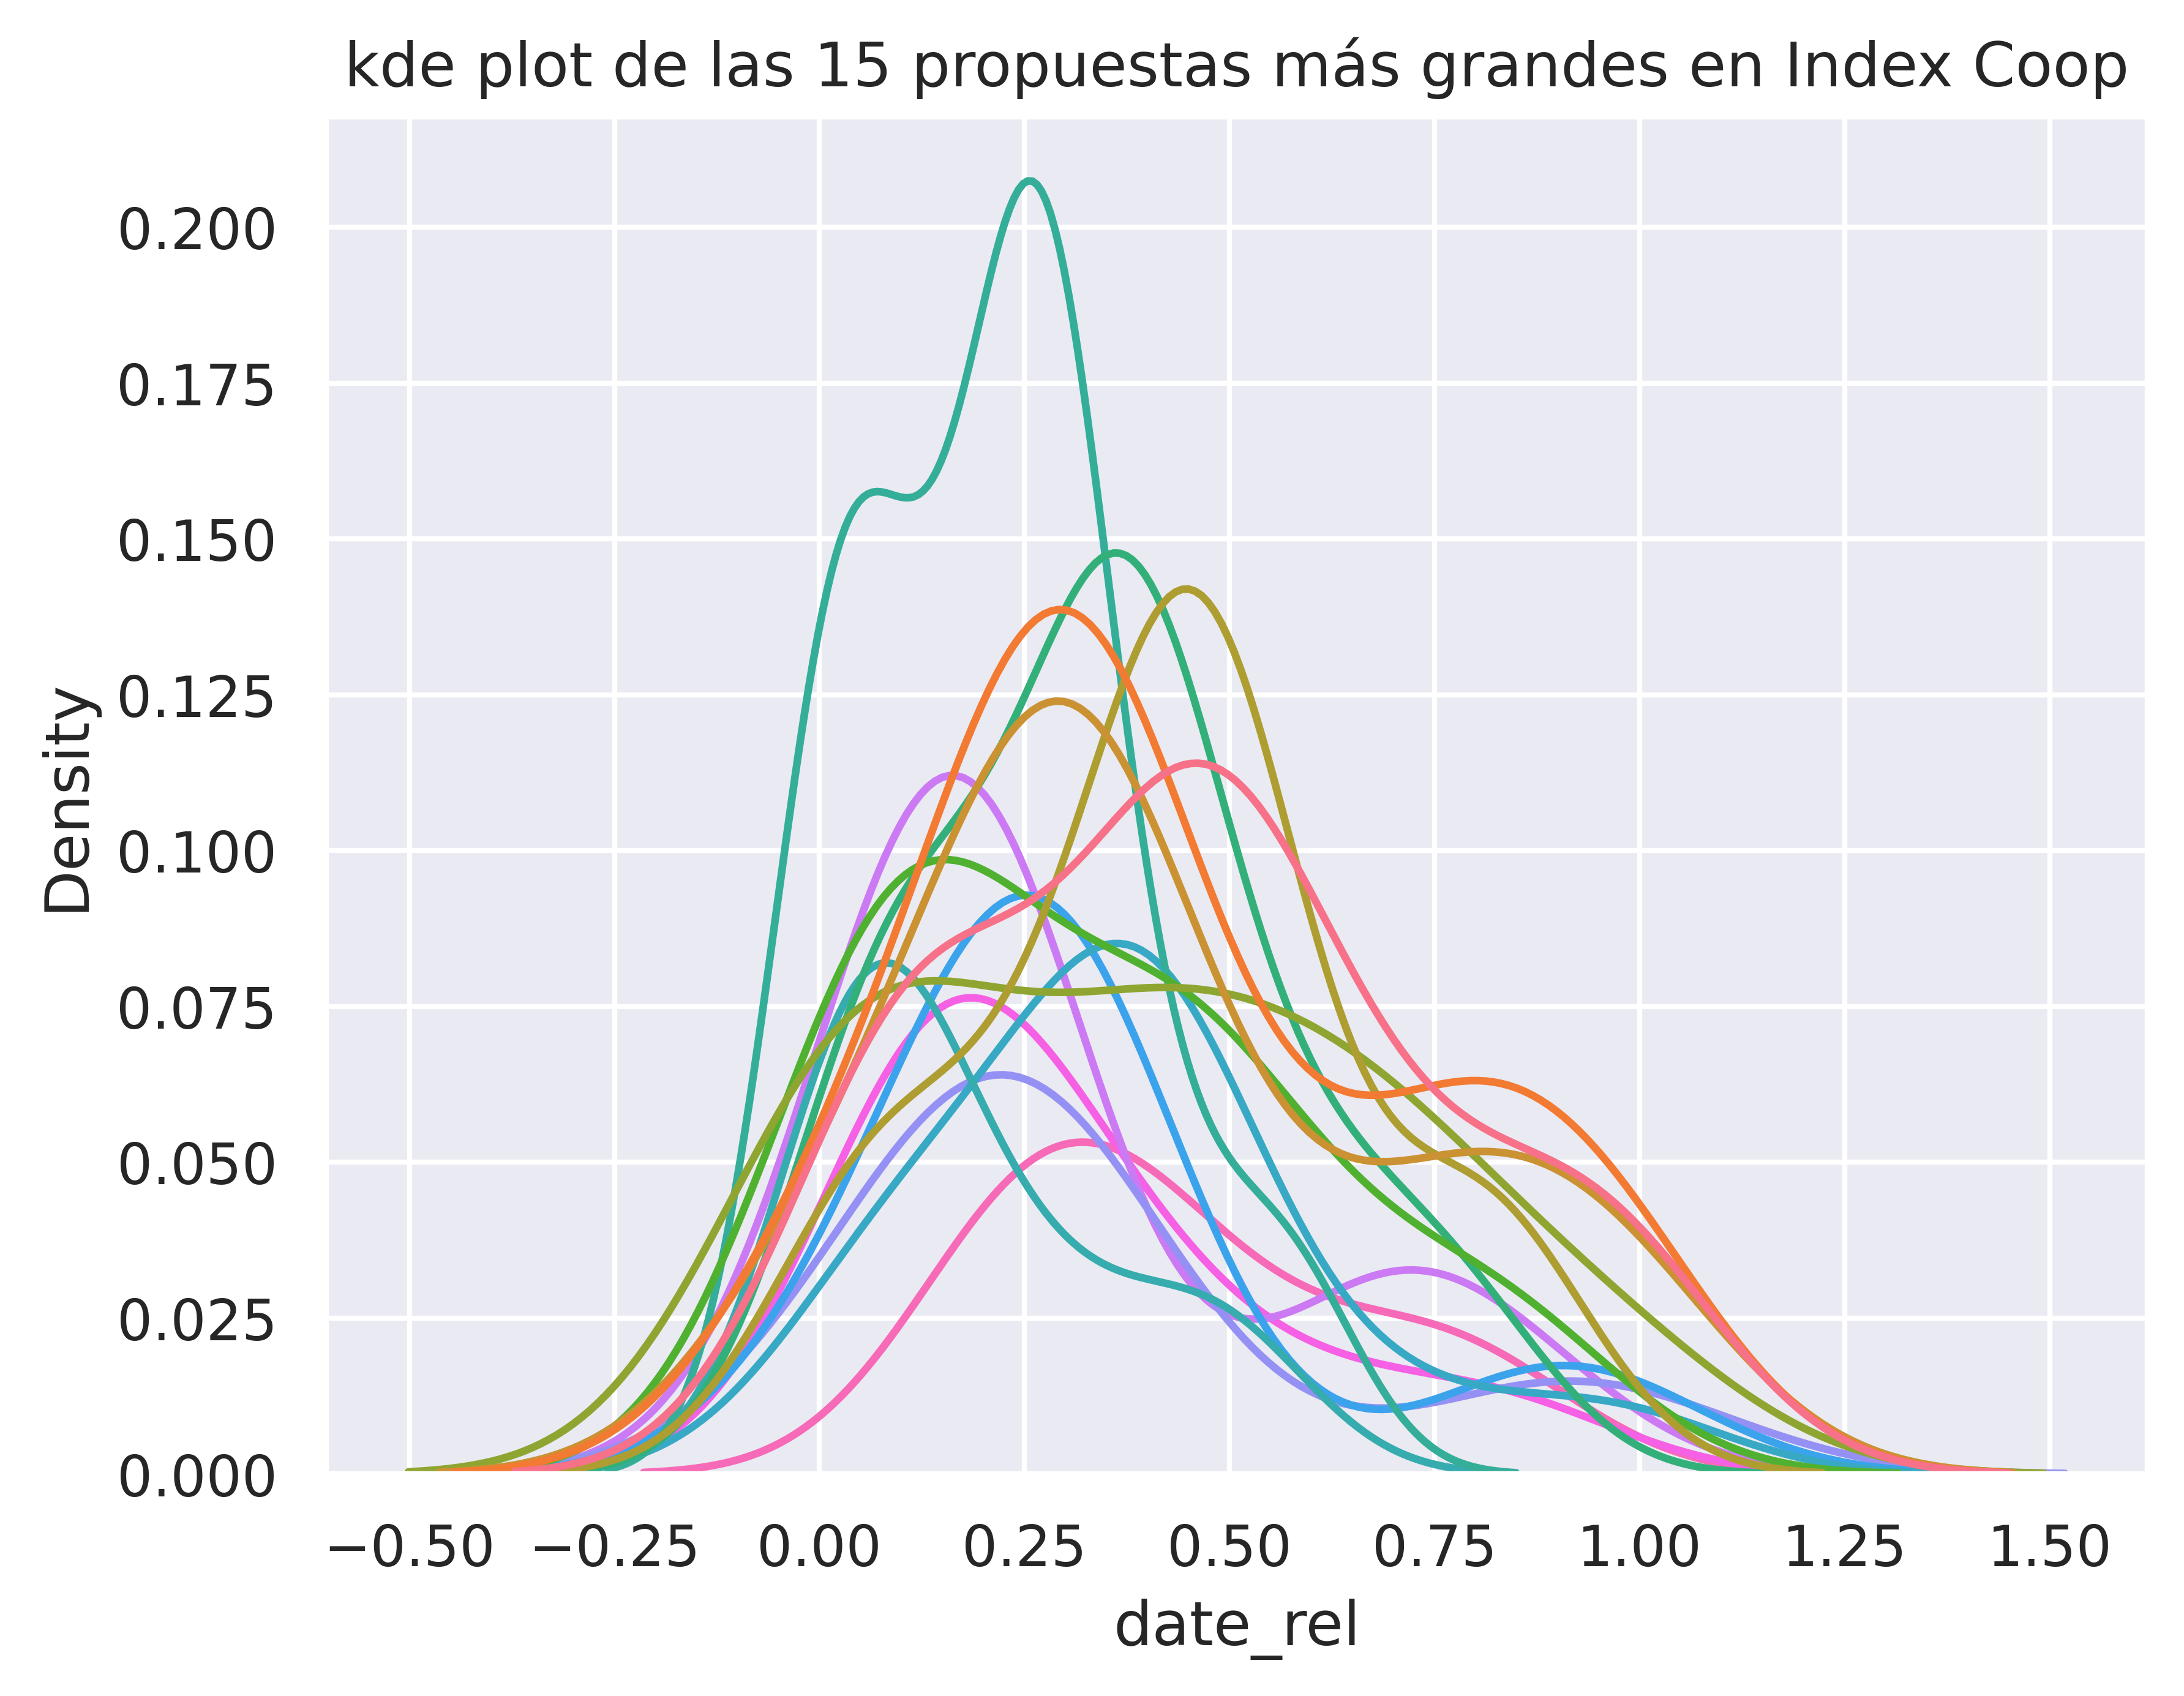

In [26]:
# Get N random proposals
# proposals = np.random.choice(_dfv2['proposal'].unique(), 15, replace=False, p=_dfv2.groupby('proposal').size() / _dfv2.groupby('proposal').size().sum())

# Get top N proposals
proposals = _dfv2.groupby('proposal').size().tail(15).index

_toplot = _dfv2[_dfv2['proposal'].isin(proposals)].copy()
_toplot['proposal'] = _toplot['proposal'].astype(str)
assert _toplot['proposal'].nunique() == len(proposals)
sns.kdeplot(_toplot, x='date_rel', hue='proposal', legend=False).set_title(f"kde plot de las 15 propuestas más grandes en {ORG_NAME}")

Efectivamente, los votos se realizan sobre todo nada más crearse la propuesta. El 25% de los votos ya han sido emitidos cuando aún queda un 95% del tiempo restante, y solo un 22% votan en la segunda mitad del tiempo disponible. Sin embargo, como podemos observar en la figura de `[kde plot de las 15 propuestas más grandes]`, hay propuestas en las que al final puede haber un pequeño repunte de actividad. Recordemos que en las DAOs el resultado de la votación es siempre visible, lo que puede sesgar la participación si los usuarios piensan que el resultado es estable y no va a cambiar.

Al partir el dataset en puntos aleatorios considerando una distribución uniforme, lo más seguro es que nos encontremos que las propuestas con las que entrenamos y testeamos (las _frontera_), tengan, en general más votos en el conjunto de entrenamiento que en el de test. Por esta razón también es necesario un sistema que sea muy resiliente al problema de cold start.